<a href="https://colab.research.google.com/github/0Tia/Hakahton/blob/main/DSBA_NLP_EXERCISE3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install sacrerouge sacrebleu bert-score

!git clone https://github.com/huggingface/transformers.git
!pip install ./transformers/.

fatal: destination path 'transformers' already exists and is not an empty directory.
Processing ./transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.5.0.dev0-cp37-none-any.whl size=2059073 sha256=6020f3fcedb8ca86b000478db67b0c95bb650a3bc4ea30ae8059baa1ae65afe7
  Stored in directory: /tmp/pip-ephem-wheel-cache-dzqjt45v/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
Successfully built transformers
  Found existing installation: transformers 4.5.0.dev0
    Uninstalling transformers-4.5.0.dev0:
      Successfully uninstalled transformers-4.5.0.dev0


## Xtreme Abstractive summarization 

[More details on the dataset](https://huggingface.co/datasets/xsum)

In [ ]:
from datasets import load_dataset

# loading dataset
train_dataset = load_dataset('xsum', split='train')
valid_dataset = load_dataset('xsum', split='validation')
test_dataset = load_dataset('xsum', split='test')

# in this example we will use only one batch containing 10 examples 
batch_input = test_dataset["document"][0:10]
batch_output = test_dataset["summary"][0:10]

Using custom data configuration default
Reusing dataset xsum (/root/.cache/huggingface/datasets/xsum/default/1.2.0/f9abaabb5e2b2a1e765c25417264722d31877b34ec34b437c53242f6e5c30d6d)
Using custom data configuration default
Reusing dataset xsum (/root/.cache/huggingface/datasets/xsum/default/1.2.0/f9abaabb5e2b2a1e765c25417264722d31877b34ec34b437c53242f6e5c30d6d)
Using custom data configuration default
Reusing dataset xsum (/root/.cache/huggingface/datasets/xsum/default/1.2.0/f9abaabb5e2b2a1e765c25417264722d31877b34ec34b437c53242f6e5c30d6d)


# Model 

**BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension [Paper](https://arxiv.org/abs/1910.13461) | [usage](https://huggingface.co/transformers/model_doc/bart.html) | [Model card](https://huggingface.co/facebook/bart-large)**

The Bart model was proposed in BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension by Mike Lewis, Yinhan Liu, Naman Goyal, Marjan Ghazvininejad, Abdelrahman Mohamed, Omer Levy, Ves Stoyanov and Luke Zettlemoyer.

Normally BART would need to be finetuned for XSUM to be able to run on this task for this we will use `distilbart-xsum-6-6` a smaller version of bart that is finetuned already on the Xsum dataset. 


In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

# Each model has a name on the hugging face website: you can search through the list of all models here https://huggingface.co/models
model = BartForConditionalGeneration.from_pretrained("sshleifer/distilbart-xsum-6-6")
# usually each model has a special tokenizer these tokenizers contain the vocabulary dictionary of all the tokens you should find the one that works with the model you use
# usually they have the same name but for the model "sshleifer/distilbart-xsum-6-6" which is made by the community we know that it is an adaptation of BART model so 
# it works with the BART tokenizer.
tok = BartTokenizer.from_pretrained("facebook/bart-base")  ## tokenizer

In [ ]:
# using our loaded tokenizer: we will encode the input documents into 
# max_length is 1024 as the bart model allows to accept 1024 tokens max as an input 
input_encodings = tok.batch_encode_plus(batch_input, padding=True, max_length=1024, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(batch_output, padding=True, max_length=1024, truncation=True, return_tensors="pt")

In [ ]:
# move our model and batch to the gpu
# comment the line below if you don't need a gpu (will be slower though)
model.to("cuda")
input_encodings.to("cuda")

{'input_ids': tensor([[    0, 35515,   556,  ...,   981, 33385,     2],
        [    0,   113,   133,  ...,     1,     1,     1],
        [    0,   133,   395,  ...,     1,     1,     1],
        ...,
        [    0, 40420, 19508,  ...,     1,     1,     1],
        [    0,   113, 29220,  ...,     1,     1,     1],
        [    0, 40066,  3730,  ...,  2182, 11826,     2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')}

In [ ]:
# Given the batch Decode the answer from your model note that model.generate function takes many params, it will operate as greedy decoding if none is given. 
model_output = model.generate(input_encodings["input_ids"])

In [ ]:
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))

source:	 Fast forward about 20 years, and it's fair to say he has done just that.
The business he runs, Frasers Hospitality, is one of the world's biggest providers of high-end serviced apartments. Its 148 properties span about 80 capital cities, as well as financial hubs across Europe, Asia, the Middle East and Africa.
But it almost didn't get off the ground.
When Mr Choe was appointed to launch and lead the company, Asia was booming; the tiger economies of Hong Kong, South Korea, Taiwan and Singapore were expanding rapidly.
But as Frasers prepared to open its first two properties in Singapore, the Asian financial crisis hit.
It was 1997. Currencies went into freefall. Suddenly, people were losing their jobs and stopped travelling.
Mr Choe recalls asking staff if they really wanted to continue working with the firm, because when the properties opened they might not get paid.
"It was really that serious," he says. "I remember tearing up because they said 'let's open it, let's open it w

# Evaluations 

In [ ]:
import bert_score
import sacrebleu
import pandas as pd 

percision,recall,fscore = bert_score.score(cands=model_output_decoded, refs=batch_output, lang="en")
bleu = sacrebleu.corpus_bleu(model_output_decoded, [batch_output]).score


df = pd.DataFrame({
    "BLEU":bleu,
    "BERTSCORE-percision": [float(percision.mean())],
    "BERTSCORE-recall": [float(recall.mean())],
    "BERTSCORE-fscore": [float(fscore.mean())]
    })

df

,BLEU,BERTSCORE-percision,BERTSCORE-recall,BERTSCORE-fscore
0,8.413534,0.911807,0.901518,0.906513


# Exercise 3

Welcome to your last exercise in this learning journey :). 
We provide you with a notebook containing an example on how to load a pretrained model inside the hugging face library and use it for generation tasks, we would like to ask you to do the same using other models and evaluate on other datasets. 

In particular, in this excercise you will be a master in loading Pretrained models (like T5), writing your own decoding algorithms, as well as investigating what is happening under the hood by interpreting their decisions. You will be (almost) an expert on three tasks Machine Translation, Summarization and Question Answering. 

The notebook contains some examples showing some guiding examples based on BART model. This model is a pretrained one that needs finetuning on the target task to perform well. The cool thing about T5 that it is trained jointly on many tasks both supervised and unsupervised such as LM, translation, summarization and question answering by reforming all tasks as "text" to "text". "For example, automatic summarization is done by feeding in a document
followed by the text “Summarize:” and then the summary is predicted via autoregressive decoding." In this excercise you will have to append those tokens yourself in the input to the model to be able to use it as a summarization model. 

-----

# TASK1: 

## 1.1 Use T5 model on new tasks and dataset
 
### T5 

 - Note: For this exercise you would need to get last dev version (`4.4.0.dev0`) of transformers from github
 
 ```
 git clone https://github.com/huggingface/transformers.git
 %cd transformers
 pip install .
```
 - You will use `t5-small` pretrained model from Hugging Face: https://huggingface.co/t5-small

 - The documentation of T5 class can be found here: https://huggingface.co/transformers/model_doc/t5.html
 
 To know more about T5 model: 
  - Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer (https://arxiv.org/pdf/1910.10683.pdf)
  - Stanford guest lecture about T5: http://web.stanford.edu/class/cs224n/slides/cs224n-2021-lecture14-t5.pdf

### New Tasks & Datasets   
- Translation: `bible_para` (https://huggingface.co/datasets/bible_para), `ted_talks_iwslt` (https://huggingface.co/datasets/ted_talks_iwslt) 
- Summarization : `cnn-dailymail` (https://huggingface.co/datasets/cnn_dailymail) 
- Question answering: BoolQ dataset (https://huggingface.co/datasets/boolq)


**Note:** `t5-small` can not handle sequences longer than 512 max_length; you would need to preprocess your datasets accordingly as done above in the tokenizer.

For each task you should give a certain prefix augemented to the input (e.g. "translate English to German: " to be able to translate an english input to german) to know each task prefix consider looking into the config https://huggingface.co/t5-small/blob/main/config.json . 


### Deliverable 1.1  (1 pt)
**OUTPUT:** print some examples from the test/validation split of each task showing the input/model output/ target reference.

## 1.2 - Implement Extra evaluation Metrics

- Summarizaiton: ROUGE (https://www.aclweb.org/anthology/W04-1013.pdf)
- MT: BLEU (https://www.aclweb.org/anthology/P02-1040/)
- Question Answering : exact match and macro-F1 (https://arxiv.org/pdf/1606.05250.pdf) 
- For those you will need a tokenizer you can use an existing implementation of the [MOSES tokenizer](https://pypi.org/project/mosestokenizer/) 
### Deliverable 1.2 (2 pt)
 - implement evaluation metrics : BLEU, ROUGE
 - Select ~1000 sentences from each of the datasets (use `test` when available, or `validation` split otherwise)
 - **Table1**: Evaluate your model on those Metrics
 - **Table2**: As a sanity check of your implementation use already existing implementation online of those metrics and compare them together with your implementation. 

## 1.3- Implement Decoding methods your own
Now you are not allowed to use the existing implementation of the function `model.generate`. [Read here about different usages of this function including many decoding algorithms beam, sampling, top-k and nucleus sampling](https://huggingface.co/blog/how-to-generate)

- **Implement a beam search** generation function that takes beamsize as a function parameter. 
- **Implement a Nucleus sampling** function that samples from a model using Nucleus sampling taking top-p as a function parameter. 
- **Implement Softmax with Temperature** function that samples from a model using Sampling with Temperature taking temperature(t) as a function parameter. 

### Deliverable 1.3 (8pt)

- **Table1:** Check Correctness of your implementation, in a table show a comparison between results obtained from model.generate function and your implementation for different beam-sizes for beamsearch and top-p 

- **Table2:** Compare between different decoding methods. for summarization and machine translation and question answering try different decoding methods for example try changing the top-p value in the nucleus sampling algorithm the temperature of the softmax and with the beamsize in the beam search (for this only you are allowed to use model.generate and existing implementation of evaluation metrics
- **Short Report 300 words max:** Given the results you obtained above. Write a short report containing your conclusions on which are the best decoding algorithm / parameter for each task. Why do you think they are the best? Does increasing the beam size usually give better scores? Why or Why not?

---------------

# Task 2 Attention Visualization 

The goal of this exercise is to understand whether (and how) the attention can be used to interpret model's behaviour. 

## 2.1 Implement cross-attention matrix vizualization
Select several examples for each task and manually examine the attention patterns for each of those tasks. What are your observations? Is there any difference in attention patterns; is there any common patterns? 

### Deliverable 2.1 (3 pt)
**Plots:** You are expected to output plots similar to those in [this blogpost](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
(section attention visualization). 

We expect you to visualize at least three plots showing any of the following
- Vizualize attention matrices per each head and each layer
- Try to aggregate the attention values across heads/layers.
- Consider examples from different categories that would take into account: model performance (hard vs easy examples), input length, different task.

**Short report max 300 words:** Add below each of the attention values above. Your comments Highlighting those patterns and what do you observe: eg. common or different patterns across tasks, how those patterns change across layers, individual attention heads versus aggregated attention patterns, any other observations. 

## 2.2 Implement Attention Matrix Aggregation
Manual examination allows to get an intuition of what attention patterns are. Aggregation metrics allow to make corpus-wide conclusions about the roles of different attention heads. Check (this paper)[https://www.aclweb.org/anthology/P19-1580/]  for more details. Implement one of the "aggregation" metrics proposed in that paper : confidence score or LRP. Compare the attention patterns across the tasks.  

### Deliverable 2.2  (4 pt) 
- **Plots and short report:** Implement one of these methods for Attention aggregation (Condifence score or LRP) and plot 3 plots showing some of the aspects above  



----------------------------------


# Bonus 1 (experiment with finetuning)
 - Take any available model on Hugging face which was trained/fine-tuned specifically for the above mentioned tasks (translation, summarization, question answering)
 - Perform task 1 and task 2 with those task-adapted models; Compare it to T5 performance/behaviour.  


## Deliverable Bonus 1 (3pt)
- **Table:** On a single task compare task 1 and 2 using several evaluation metrics and interpretability measures from the above (you can use existing implementation for those metrics). 
- **Short report 300 words max** : comment on What is common and different between these models in terms of interpretability and evaluation metrics? Does the finetuned model perform better than T5 model who was trained on all tasks together? Why would you use one instead of the other? 


# Bonus 2 (implement Minimum Bayes Risk Decoding)
Neural Language Generation models are silly what they believe the highest likely sequence is usually an empty sequence (`<s></s>`) This problem is demonstrated in the following paper: [On NMT Search Errors and Model Errors: Cat Got Your Tongue?](https://www.aclweb.org/anthology/D19-1331/).

This problem is puzzling many scientists at the moment. A method to overcome is to sample many output of the model and rank them according to their pairwise utility. This is a tracktable approximation of a method called Minimum bayes risk decoding. That has been recently proposed in this recent work [Is MAP Decoding All You Need? The Inadequacy of the Mode in Neural Machine Translation](https://arxiv.org/pdf/2005.10283.pdf).
<img src=https://i.imgur.com/J0ePay7.png width=500>

In this bonus task we ask you to implement this decoding method as the two one above (you can use any utility function of your choice in the paper they use METEOR python implementation is available online e.g. here https://pypi.org/project/textmetrics/).

## Deliverable Bonus 2 (5pt):
- **Table:** Compare MBR decoding vs Beam search with beam size=5, beam size=10, beam size=15 other on machine translation task above.  
- **Short Report 300 words max:** Given the results you obtained above. Write a short report containing your conclusions. What on which are the best decoding algorithm / parameter for each task. Why is that? what are your conclusions?  

------------------

# Summary of All Deliverables
Overall you have Two tasks with 8 deliverables with 3 optional ones: 
- Deliverable 1.1  (1 pt) 
- Deliverable 1.2 (2 pt)
- Deliverable 1.3 (8pt)
- Deliverable 2.1 (3 pt)
- Deliverable 2.2  (4 pt) 
- Deliverable Bonus 1 (3pt)
- Deliverable Bonus 2 (5pt):

# Submit your Exercise

- All deliverables are expected to be submitted in a single colab notebook. 
- In your notebook please highlight each deliverable by its title (e.g. # Deliverable 1.2)..etc
- Please stick to the format of each deliverable being a table short report or a plot as identified above 
- Please name your notebook  on the following format  DSBA_EXCERCISE3_FIRSTNAME_LASTNAME
(where firstname and lastname are those of the one who will submit the exercise on behalf of the team)

Submit your excercise by filling the following form (one submission per team): https://forms.gle/nqkcUw3v6oLxHEQJ6


# Task 1 

## **Deliverable 1.1**
## USe T5 model on new tasks and dataset

### Installations

In [ ]:
!git clone https://github.com/huggingface/transformers.git
%cd transformers
!pip install .
# # % pip install sentencepiece

fatal: destination path 'transformers' already exists and is not an empty directory.
/content/transformers
Processing /content/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.5.0.dev0-cp37-none-any.whl size=2059073 sha256=b5f6f3a26440320ed743fba9fad239e859e3ec7d0707a33cb76d861fb6b31f46
  Stored in directory: /tmp/pip-ephem-wheel-cache-i0zfhsx2/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
Successfully built transformers
  Found existing installation: transformers 4.5.0.dev0
    Uninstalling transformers-4.5.0.dev0:
      Successfully uninstalled transformers-4.5.0.dev0


### Loading databases and creating batches

In [ ]:
from datasets import load_dataset

# loading dataset
dataset_bible = load_dataset("bible_para", lang1="en", lang2="fr", split = 'train')
dataset_ted = dataset = load_dataset("ted_talks_iwslt", language_pair=("en", "fr"), year="2014", split = 'train')
dataset_cnn = load_dataset("cnn_dailymail", '3.0.0', split = 'train', download_mode='force_redownload')
dataset_boolq = load_dataset("boolq", split = 'train')

# in this example we will use only one batch containing 10 examples

# Bible
batch_input_bible = [dataset_bible['translation'][i]['en'] for i in range(10)]
batch_input_bible = ['translate English to French: ' + s for s in batch_input_bible]
batch_output_bible = [dataset_bible['translation'][i]['fr'] for i in range(10)]

# TED
batch_input_ted = [dataset_ted['translation'][i]['en'] for i in range(10)]
batch_input_ted = ['translate English to French: ' + s for s in batch_input_ted]
batch_output_ted = [dataset_ted['translation'][i]['fr'] for i in range(10)]

# CNN
batch_input_cnn = dataset_cnn['article'][0:10]
batch_input_cnn = ['summarize: ' + s for s in batch_input_cnn]
batch_output_cnn = dataset_cnn['highlights'][0:10]

# BoolQ
batch_input_boolq = ['question: ' + dataset_boolq['question'][i] + '  context: ' + dataset_boolq['passage'][i] for i in range(10)]
batch_output_boolq = [dataset_boolq['answer'] for i in range(10)]

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)
Using custom data configuration en_fr_2014-92f06b6025874f80
Reusing dataset ted_talks_iwslt (/root/.cache/huggingface/datasets/ted_talks_iwslt/en_fr_2014-92f06b6025874f80/1.1.0/caf519a0a183db297ca5f39dbfd42de3a415aaa79b5a638edd4fd7a3e3b0e545)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)


### Initiate T5-small model and Tokenizer

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config
# default config to the model which is the t5-small configuration according to the documentation
config = T5Config()

# we instanciate a T5 model that has the same architecture as the t5-small and then load the t5-small into it
model = T5ForConditionalGeneration(config).from_pretrained('t5-small')

In [ ]:
# !pip install sentencepiece

In [ ]:
import sentencepiece
# instanciate pretrained tokenizer for t5-small
tok = T5Tokenizer.from_pretrained("t5-small")  ## tokenizer

### Print examples of tasks

In [ ]:
def T5_output(model, batch_input, batch_output, show_examples = False):
    batch_input_ids = tok(batch_input, return_tensors='pt', padding = True, max_length = 512, truncation = True).input_ids
    model_output_ids = model.generate(batch_input_ids)
    model_output = tok.batch_decode(model_output_ids, skip_special_tokens=True)
    if show_examples == True :
        for s,t,g in zip(batch_input[:5], batch_output[:5], model_output[:5]):
            print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))
    return model_output

### Bible

In [ ]:
model_output_bible =  T5_output(model, batch_input_bible, batch_output_bible, show_examples = True)

source:	 translate English to French: In the beginning God created the heavens and the earth.
target:	Au commencement, Dieu créa les cieux et la terre.
generated	Au début, Dieu créa les cieux et la terre.
------

source:	 translate English to French: Now the earth was formless and empty. Darkness was on the surface of the deep. God's Spirit was hovering over the surface of the waters.
target:	La terre était informe et vide: il y avait des ténèbres à la surface de l`abîme, et l`esprit de Dieu se mouvait au-dessus des eaux.
generated	Maintenant, la terre était sans forme et vide, la fébril
------

source:	 translate English to French: God said, "Let there be light," and there was light.
target:	Dieu dit: Que la lumière soit! Et la lumière fut.
generated	Dieu a dit : « La lumière ne s'en trouve pas
------

source:	 translate English to French: God saw the light, and saw that it was good. God divided the light from the darkness.
target:	Dieu vit que la lumière était bonne; et Dieu sépara l

### TED

In [ ]:
model_output_ted =  T5_output(model, batch_input_ted, batch_output_ted, show_examples = True)

source:	 translate English to French: In the pitch-black night, stung by jellyfish, choking on salt water, singing to herself, hallucinating … Diana Nyad just kept on swimming. And that's how she finally achieved her lifetime goal as an athlete: an extreme 100-mile swim from Cuba to Florida -- at age 64. Hear her story.
target:	Dans la noirceur de la nuit, piquée par des méduses, s'étranglant avec l'eau salée, chantant pour elle-même, hallucinant... Diana Nyad a continué à nager. C'est ainsi qu'elle a finalement atteint l'objectif de sa vie d'athlète : nager 165 km, depuis Cuba jusqu'à la Floride, à 64 ans. Ecoutez son histoire.
generated	l'époque, Diana Nyad a fini par atteindre son
------

source:	 translate English to French: Diana Nyad: Never, ever give up
target:	Diana Nyad: N'abandonnez jamais !
generated	Diana Nyad : Ne jamais renoncer à l'action
------

source:	 translate English to French: Almost everything we own and use, at some point, travels to us by container ship, throug

### CNN

In [ ]:
model_output_cnn =  T5_output(model, batch_input_cnn, batch_output_cnn, show_examples = True)

source:	 summarize: It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction." It's a step that is set to turn an international crisis into a fierce domestic political battle. There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react? In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- bu

### BoolQ

In [ ]:
model_output_boolq =  T5_output(model, batch_input_boolq, batch_output_boolq, show_examples = True)

source:	 question: do iran and afghanistan speak the same language  context: Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.
target:	[True, True, True, True, False, False, False, False, True, True, False, False, False, True, True, False, False, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, False, False, False, True, True, False, False, False, False, True, False, True, True, True, False, False, True, True, True, 

## **Deliverable 1.2**
## Implement Extra Evaluation Metrics

### Blue Implementation 

In [ ]:
import numpy as np
import string
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd

def get_ngram(sentence,n=2):
  '''return a list of n-gram, bigram by default
  '''
  # remove punctuations
  s = sentence.translate(str.maketrans('', '', string.punctuation))
  words = s.lower().split(' ')
  ngrams = []
  for i in range(len(words)-n+1):
    ngrams.append(' '.join(words[i:i+n]))
  
  counts = Counter(ngrams)
  return ngrams,counts

In [ ]:
def bleuscore(reference, candidate, weights = (0.25, 0.25, 0.25, 0.25)):
    result = np.zeros(4)
    
    for n_grams_size in range(1, 5):
        _, ref_count = get_ngram(reference, n = n_grams_size)
        _, cand_count = get_ngram(candidate, n = n_grams_size)


        # counts_clip = min(counts, max_ref)
        # note that if not in counts then counts = 
        count_clip = Counter()
        for k, v in cand_count.items():
            count_clip[k] = min(v, ref_count[k])
        
        if sum(cand_count.values()) != 0:
            frac = sum(count_clip.values()) / sum(cand_count.values())
        else:
            return 1
        result[n_grams_size-1] = frac



    if len(candidate.split())>len(reference.split()):
        bp = 1
    else:
        bp = np.exp(1-len(reference.split())/len(candidate.split()))

    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.log(result)
        result[np.isneginf(result)]=0
        return bp * np.exp(np.sum(weights*result))

Evaluating Bleu over 1000 sentences

In [ ]:
batch_input_bible = []
batch_output_bible = []

data = dataset_bible['translation']
for i in range(1000):
    item = data[i]
    batch_input_bible.append('translate English to French: ' + item['en'])
    batch_output_bible.append(item['fr'])

In [ ]:
model_output_bible =  T5_output(model, batch_input_bible, batch_output_bible)

In [ ]:
bible_bleu_results = pd.DataFrame(columns=['original', 'human-translation', 't5-translation', 'nltk-bleu', 'our-bleu'])

for i in range(1000):
    row = {'original': batch_input_bible[i], 
                            'human-translation': batch_output_bible[i],
                            't5-translation': model_output_bible[i],
                            'nltk-bleu': sentence_bleu([batch_output_bible[i].split()], model_output_bible[i].split()),
                            'our-bleu': bleuscore(batch_output_bible[i],model_output_bible[i])}

    bible_bleu_results = bible_bleu_results.append(row, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
bible_bleu_results

,original,human-translation,t5-translation,nltk-bleu,our-bleu
0,translate English to French: In the beginning ...,"Au commencement, Dieu créa les cieux et la terre.","Au début, Dieu créa les cieux et la terre.",0.750624,0.750624
1,translate English to French: Now the earth was...,La terre était informe et vide: il y avait des...,"Maintenant, la terre était sans forme et vide,...",0.102450,0.088724
2,"translate English to French: God said, ""Let th...",Dieu dit: Que la lumière soit! Et la lumière fut.,Dieu a dit : « La lumière ne s'en trouve pas,0.652994,0.436684
3,translate English to French: God saw the light...,Dieu vit que la lumière était bonne; et Dieu s...,Dieu a vu la lumière et a vu qu'elle était bonne.,0.320973,0.399505
4,translate English to French: God called the li...,"Dieu appela la lumière jour, et il appela les ...","Dieu a appelé la lumière « jour », et l'obscur...",0.093107,0.098449
...,...,...,...,...,...
995,translate English to French: Only on this cond...,Nous ne consentirons à votre désir qu`à la con...,"cette condition, nous vous consentrons à l'éga...",0.161951,0.192593
996,translate English to French: then will we give...,"Nous vous donnerons alors nos filles, et nous ...","Alors nous donnerons nos filles à vous, et nous",0.082912,0.098600
997,translate English to French: But if you will n...,Mais si vous ne voulez pas nous écouter et vou...,"Mais si vous ne nous écoutez pas, à être circons",0.092459,0.096771
998,translate English to French: Their words pleas...,Leurs paroles eurent l`assentiment de Hamor et...,"Leurs paroles ont ravi Hamor et Shechem, le fi...",0.547518,0.547518


In [ ]:
# RMSE between our implementation and NLTKs implementation is at 0.04 (mostly due to different treatment of cases with no matches of n-grams)
np.average(np.sqrt((bible_bleu_results['nltk-bleu'] - bible_bleu_results['our-bleu'])**2))

0.0446397511846093

In [ ]:
batch_input_ted = []
batch_output_ted = []

data = dataset_ted['translation']
for i in range(1000):
    item = data[i]
    batch_input_ted.append('translate English to French: ' + item['en'])
    batch_output_ted.append(item['fr'])

model_output_ted =  T5_output(model, batch_input_bible, batch_output_bible)

ted_bleu_results = pd.DataFrame(columns=['original', 'human-translation', 't5-translation', 'nltk-bleu', 'our-bleu'])

for i in range(1000):
    row = {'original': batch_input_bible[i], 
                            'human-translation': batch_output_ted[i],
                            't5-translation': model_output_ted[i],
                            'nltk-bleu': sentence_bleu([batch_output_ted[i].split()], model_output_ted[i].split()),
                            'our-bleu': bleuscore(batch_output_ted[i],model_output_ted[i])}

    ted_bleu_results = ted_bleu_results.append(row, ignore_index=True)


print(np.average(np.sqrt((ted_bleu_results['nltk-bleu'] - ted_bleu_results['our-bleu'])**2)))

In [ ]:
ted_bleu_results

,original,human-translation,t5-translation,nltk-bleu,our-bleu
0,translate English to French: In the beginning ...,"Dans la noirceur de la nuit, piquée par des mé...","Au début, Dieu créa les cieux et la terre.",0.006067,0.006067
1,translate English to French: Now the earth was...,Diana Nyad: N'abandonnez jamais !,"Maintenant, la terre était sans forme et vide,...",0.000000,0.000000
2,"translate English to French: God said, ""Let th...",90% du commerce mondial est transporté via la ...,Dieu a dit : « La lumière ne s'en trouve pas,0.013210,0.013210
3,translate English to French: God saw the light...,Rose George: Les secrets de l'industrie maritime,Dieu a vu la lumière et a vu qu'elle était bonne.,0.000000,0.000000
4,translate English to French: God called the li...,Le philosophe Stephen Cave commence par une qu...,"Dieu a appelé la lumière « jour », et l'obscur...",0.002126,0.002126
...,...,...,...,...,...
995,translate English to French: Only on this cond...,Monika Bulaj : La lumière cachée d'Afghanistan,"cette condition, nous vous consentrons à l'éga...",0.000000,0.000000
996,translate English to French: then will we give...,Qu'est-ce qu'une erreur ? En nous parlant au t...,"Alors nous donnerons nos filles à vous, et nous",0.019423,0.019423
997,translate English to French: But if you will n...,Stefon Harris : Il n'y a pas d'erreur sur scène,"Mais si vous ne nous écoutez pas, à être circons",0.000000,0.562341
998,translate English to French: Their words pleas...,Imaginez une opération chirurgicale sans bist...,"Leurs paroles ont ravi Hamor et Shechem, le fi...",0.018272,0.018272


### Rouge Scores for summarization

Note: Due to the downloading issues with the CNN dataset we weren't able to run the experiments directly on the dataset

However, we leave the source code for this experiment in case the issues are resolved between the submission date and the corretion date

In [ ]:
batch_input_cnn = []
batch_output_cnn = []

articles = dataset_cnn['article']
highlights = dataset_cnn['highlights']
for i in range(1000):
    item = data[i] 
    batch_input_cnn.append('summarize: ' + articles[i])
    batch_output_ted.append(highlights[i])

In [ ]:
def rouge1(reference,candidate):
    ngrams_can,counts_can = get_ngram(candidate,1)  # using the get_ngram function written in BLEU implementation
    ngrams_ref,counts_ref = get_ngram(reference,1)
    count_match = 0
    for i in ngrams_can:
      if i in ngrams_ref:
        count_match += 1 # computing coocurrence of unigram

    count_ref = len(ngrams_ref)
    count_can = len(ngrams_can)

    rouge_recall = count_match/count_ref
    if count_can == 0:  # when the model output returns empty 
      rouge_precison = 0
    else:
      rouge_precison = count_match/count_can

    rouge_fmeasure = (2*rouge_recall*rouge_precison)/(rouge_recall+rouge_precison)
    print('rouge1: precison={}, recall={}, fmeasure={}'.format(rouge_precison,rouge_recall,rouge_fmeasure))
    return rouge_precison,rouge_recall,rouge_fmeasure

In [ ]:
def lcs(X , Y):
    # find the length of the strings
    m = len(X)
    n = len(Y)
  
    # declaring the array for storing the dp values
    L = [[None]*(n+1) for i in range(m+1)]
  
    """Following steps build L[m+1][n+1] in bottom up fashion
    Note: L[i][j] contains length of LCS of X[0..i-1]
    and Y[0..j-1]"""
    for i in range(m+1):
        for j in range(n+1):
            if i == 0 or j == 0 :
                L[i][j] = 0
            elif X[i-1] == Y[j-1]:
                L[i][j] = L[i-1][j-1]+1
            else:
                L[i][j] = max(L[i-1][j] , L[i][j-1])
  
    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1]
    return L[m][n]

def rougeL(reference,candidate):
    ngrams_can,_ = get_ngram(candidate,1) 
    ngrams_ref,_ = get_ngram(reference,1)
    lcs_count = lcs(ngrams_can,ngrams_ref)
    m = len(ngrams_ref)
    n = len(ngrams_can)
    
    # recall
    R_lcs = lcs_count/m
    #precison
    if n != 0:
      P_lcs = lcs_count/n
    else:
      P_lcs = 0
    #fmeasure
    beta = P_lcs/R_lcs
    fmeasure = ((1+beta**2)*P_lcs*R_lcs)/(R_lcs+(beta**2)*P_lcs)
    print('rougeL: precison={}, recall={}, fmeasure={}'.format(P_lcs,R_lcs,fmeasure))
    return P_lcs,R_lcs,fmeasure

In [ ]:
pip install rouge

In [ ]:
from rouge import Rouge


hyps, refs = map(list, zip(*[  [model_output_cnn[i], batch_output_cnn[i]] for i in range(len(model_output_cnn))  ])) 
rouge = Rouge()
rogue_lib_scores = rouge.get_scores(hyps, refs, avg = True)

In [ ]:
print(rogue_lib_scores) 

In [ ]:
model_output_cnn =  T5_output(model, batch_input_cnn, batch_output_cnn)

cnn_rogue_results = pd.DataFrame(columns=['original', 'reference', 'candidate', 'rogue-library', 'our-rogue1', 'our-rogueL'])

for i in range(1000):
    row = {'original': batch_input_cnn[i], 
           'reference': batch_output_cnn[i],
           'candidate': model_output_cnn[i],
           'rogue-library': rogue_lib_scores[i],
           'our-rogue1': rouge1(batch_output_cnn[i],model_output_cnn[i]),
           'our-rogueL': rougeL(batch_output_cnn[i],model_output_cnn[i])}
    
    cnn_rogue_results = cnn_rogue_results.append(row, ignore_index=True)

In [ ]:
cnn_rogue_results

## **Deliverable 1.3**
## Implement Decoding methods your own

## Implementations

### Greedy Search

In [ ]:
import torch

def greedy_search(input_ids):
    cur_len = input_ids.shape[1]
    max_len = 100

    while cur_len<=max_len :

        model_output = model(input_ids, decoder_input_ids = input_ids,return_dict = True)
        next_token_logit = model_output.logits[0,-1,:]
        arg_max_word = torch.unsqueeze(torch.unsqueeze(torch.argmax(next_token_logit), dim = 0), dim = 0)
        input_ids = torch.cat([input_ids, arg_max_word], dim=1)
        cur_len +=1

    return tok.decode(input_ids[0], skip_special_tokens=True)

In [ ]:
batch_input_bible_token = tok(batch_input_bible, return_tensors='pt', padding = True, max_length = 512, truncation = True)
batch_input_bible_ids = batch_input_bible_token.input_ids

input_ids = torch.unsqueeze(batch_input_bible_ids[0], dim = 0)

In [ ]:
greedy_search(input_ids)

'translate English to French: In the beginning God created the heavens and the earth.'

### Beam Search

In [ ]:
import math
from torch.nn.functional import softmax

def beam_search(input_ids, k, max_len):

    # Beam Search
    model_output = model(input_ids, decoder_input_ids = input_ids,return_dict = True)
    next_token_logit = model_output.logits[0,-1,:]
    next_token_softmax = softmax(next_token_logit, dim = 0).detach()
    top_k_words = torch.topk(next_token_softmax, k )
    candidates = []

    # initialization
    for i in range(k):
        candidates.append((torch.cat([input_ids, 
                                    torch.unsqueeze(torch.unsqueeze(top_k_words.indices[i], dim = 0), dim = 0)], dim=1), 
                        math.log(top_k_words.values[i].item())))

    new_candidates = sorted(candidates, key = lambda tup : tup[1], reverse = True)[:k]
    candidates_seq_list = list(map(lambda tup : tup[0], new_candidates))
    candidates_seq = torch.cat(candidates_seq_list, dim=0)
    candidates_prob = list(map(lambda tup : tup[1], new_candidates))

    # Update the candidates and probs max_len times:
    for t in range(max_len) :
        candidates_seq, candidates_prob = beam_step(candidates_seq, candidates_prob, k)
     
    return tok.decode(candidates_seq[0], skip_special_tokens=True)

# update the pair (candidates_seq, candidates_prob) by exploring the k max values at each step
def beam_step(candidates_seq, candidates_prob, k):
    # create a batch of the candidates and pass it to the model
    # compute the probability matrix
    model_output = model(candidates_seq, decoder_input_ids = candidates_seq, return_dict = True)
    next_token_logit = model_output.logits[:,-1,:]
    next_token_softmax = softmax(next_token_logit, dim = 1).detach()
    top_k_words = torch.topk(next_token_softmax, k )

    # fill a new candidate list with the k-th best of the k-th best
    candidates = []
    for i in range(k):
        for j in range(k):
            candidates.append((torch.cat([candidates_seq[i], 
                                        torch.unsqueeze(top_k_words.indices[i][j], dim = 0)], dim=0), 
                            candidates_prob[i] + math.log(top_k_words.values[i][j].item())))

    new_candidates = sorted(candidates, key = lambda tup : tup[1], reverse = True)[:k]
    candidates_seq_list = list(map(lambda tup : torch.unsqueeze(tup[0], dim =0), new_candidates))
    candidates_seq = torch.cat(candidates_seq_list, dim=0)
    candidates_probs = list(map(lambda tup : tup[1], new_candidates))

    return candidates_seq, candidates_prob

In [ ]:
batch_input_bible_token = tok(batch_input_bible, return_tensors='pt', padding = True, max_length = 512, truncation = True)
batch_input_bible_ids = batch_input_bible_token.input_ids

input_ids = torch.unsqueeze(batch_input_bible_ids[0], dim = 0)

In [ ]:
beam_search(input_ids, k= 2, max_len = 60)

'translate English to French: God said, "Let there be light," and there was light. Dieu a dit : "Let et et et et et et et et et et et et et et et et et'

In [ ]:
beam_search(input_ids, k= 3, max_len = 60)

'translate English to French: God said, "Let there be light," and there was light. Dieu disait, Dieu disait, Dieu disait, Dieu disait, Dieu disait, Dieu disait, Dieu disait, Dieu disait, Dieu disait, Dieu disait, Dieu disait, Dieu disait, Dieu disait, Dieu disait, Dieu disait, Dieu'

### Top-p (nucleus) sampling

In [ ]:
from torch.nn.functional import softmax

def nucleus_sampling(input_ids, p):
    cur_len = input_ids.shape[1]
    max_len = 50

    # at each step
    while cur_len<=max_len :

        # get the logits
        model_output = model(input_ids, decoder_input_ids = input_ids,return_dict = True)
        next_token_logit = model_output.logits[0,-1,:]

        # instantite the top 100 words
        top_100_words = torch.topk(softmax(next_token_logit, dim = 0), 100)
        # print(top_100_words)
        prob = []
        candidates = []
        sum_prob = 0

        # add words untill the cumulative prob reaches p
        i = 0
        while sum_prob <= p :
            candidates.append(top_100_words.indices[i].item())
            prob.append(top_100_words.values[i].item())
            sum_prob = sum(prob)
            i+=1

        # normalized the prob of the words sampled
        prob_normalized = [l / sum_prob for l in prob]
        # sample a word according to a multinomial distribution
        sample_next_word = np.random.multinomial(1, prob_normalized)

        arg_next_word = np.argmax(sample_next_word)

        next_word = candidates[arg_next_word]

        # append the predicted word to the input before looping again    
        input_ids = torch.cat([input_ids, torch.unsqueeze(torch.tensor([next_word]), dim = 0)], dim=1)

        
        cur_len +=1

    return tok.decode(input_ids[0], skip_special_tokens=True)

In [ ]:
batch_input_bible_token = tok(batch_input_bible, return_tensors='pt', padding = True, max_length = 512, truncation = True)
batch_input_bible_ids = batch_input_bible_token.input_ids

input_ids = torch.unsqueeze(batch_input_bible_ids[0], dim = 0)

model_output = model(input_ids, decoder_input_ids = input_ids,return_dict = True)
next_token_logit = model_output.logits[0,-1,:]

In [ ]:
nucleus_sampling(input_ids,p = 0.7)

'translate English to French: In the beginning God created the heavens and the earth. Au début, Dieu a créé les c au'

### Softmax with temperature

In [ ]:
from torch.nn.functional import softmax

def temperature_sampling(input_ids, T=0.5):
    cur_len = input_ids.shape[1]
    max_len = 50

    # at each step
    while cur_len<=max_len :

        # get the logits
        model_output = model(input_ids, decoder_input_ids = input_ids,return_dict = True)
        next_token_logit = model_output.logits[0,-1,:]

        # compute the temperature softmax
        temperature_softmax = softmax(next_token_logit / T, dim = 0).detach()

        # pick the sample according to the temperature softmax distribution
        next_word = torch.multinomial(temperature_softmax, 1)

        # append inputs
        input_ids = torch.cat([input_ids, torch.unsqueeze(next_word, dim = 0)], dim=1)

        
        cur_len +=1

    return tok.decode(input_ids[0], skip_special_tokens=True)

In [ ]:
batch_input_bible_token = tok(batch_input_bible, return_tensors='pt', padding = True, max_length = 512, truncation = True)
batch_input_bible_ids = batch_input_bible_token.input_ids

input_ids = torch.unsqueeze(batch_input_bible_ids[0], dim = 0)

In [ ]:
temperature_sampling(input_ids, 0.8)

'translate English to French: In the beginning God created the heavens and the earth. Au début, dans le début, à partir du début'

## Deliverables

### 1. Correctness of the implementation


| Functions        | Output          |
| ------------- |-------------| 
| **input**         | translate English to French: In the beginning God created the heavens and the earth. |
| **generate**      | Au début, Dieu créa les cieux et la terre. |
| **Greedy**     | Au début, Dieu a créé les cieux et la terre      |
| **Beam Search** | Au début, Dieu a créé les cieux et la terre      | 
| **Nucleus Sampling** | Au début, Dieu a créé les c au     | 
| **Temperature Sampling** |  Au début, au début, au début,     | 

In [ ]:
greedy_search(model, input_ids)

'translate English to French: In the beginning God created the heavens and the earth. Au début, Dieu a créé les cieux et la terre au début, Dieu a créé les cieux et la terre au début, Dieu a créé les cieux et la terre au début, Dieu a créé les cieux et'

In [ ]:
beam_search(input_ids, k= 4, max_len = 60)

'translate English to French: In the beginning God created the heavens and the earth. Au début, Dieu a créé les cieux et la terre au début, Dieu a créé les cieux et la terre au début, Dieu a créé les cieux et la terre au début, Dieu a créé les cieux e'

In [ ]:
nucleus_sampling(input_ids,p = 0.7)

'translate English to French: In the beginning God created the heavens and the earth. Au début, il est tout tout tout tout tout tout'

In [ ]:
temperature_sampling(input_ids)

'translate English to French: In the beginning God created the heavens and the earth. Au début, au début, au début, au début,'

### 2. Tuning

DUE TO BUGS ON CNN DATASET WE COULD NOT PERFORM SUMMARIZATION TASK

In [ ]:
batch_input_bible[:10]

['translate English to French: In the beginning God created the heavens and the earth.',
 "translate English to French: Now the earth was formless and empty. Darkness was on the surface of the deep. God's Spirit was hovering over the surface of the waters.",
 'translate English to French: God said, "Let there be light," and there was light.',
 'translate English to French: God saw the light, and saw that it was good. God divided the light from the darkness.',
 'translate English to French: God called the light "day," and the darkness he called "night." There was evening and there was morning, one day.',
 'translate English to French: God said, "Let there be an expanse in the middle of the waters, and let it divide the waters from the waters."',
 'translate English to French: God made the expanse, and divided the waters which were under the expanse from the waters which were above the expanse; and it was so.',
 'translate English to French: God called the expanse "sky." There was evenin

In [ ]:
input_ids = tok(batch_input_bible[:10], return_tensors='pt', padding = True, max_length = 512, truncation = True).input_ids

In [ ]:
model_output_ids = model.generate(input_ids, num_beams = 1)
tok.batch_decode(model_output_ids, skip_special_tokens=True)

['Au début, Dieu créa les cieux et la terre.',
 'Maintenant, la terre était sans forme et vide, la fébril',
 "Dieu a dit : « La lumière ne s'en trouve pas",
 "Dieu a vu la lumière et a vu qu'elle était bonne.",
 "Dieu a appelé la lumière « jour », et l'obscurité qu'",
 "Dieu a dit : « Que l'on y ait une",
 "Dieu a fait l'étendue et divisé les eaux qui se",
 "Dieu a appelé l'étendue « sommeil » et il",
 'Dieu a dit : « Que les eaux sous le ciel soient rassemblées',
 'Dieu a appelé la terre sèche « terre » et la rassemblement des eaux']

In [ ]:
model_output_ids = model.generate(input_ids, num_beams = 10)
tok.batch_decode(model_output_ids, skip_special_tokens=True)

['Au début, Dieu créa les cieux et la terre.',
 "Aujourd'hui, la terre était sans forme et vide, la fonc",
 'Dieu a dit : « Il y a de la lumière », e',
 "Dieu a vu la lumière, et il a vu qu'elle était",
 "Dieu a appelé la lumière « jour », et l'obscurité qu'",
 "Dieu a dit : « Qu'il y ait une étendue",
 "Dieu a fait l'étendue et a divisé les eaux",
 'Il y a eu le soir et le matin, un deuxième',
 'Dieu a dit : « Que les eaux sous le ciel soient rassemblées',
 'Dieu a appelé la terre sèche « terre » et le rassemblement des eaux']

In [ ]:
model_output_ids = model.generate(input_ids, do_sample=True, max_length=50, top_p=0.3, temperature=0.8)
tok.batch_decode(model_output_ids, skip_special_tokens=True)

['Au début, Dieu créa les cieux et la terre.',
 "Maintenant, la terre était sans forme et vide, la foncée était sur la surface du profond, l'Esprit de Dieu a établi un arrière-plan sur",
 "Dieu a dit : « Que l'on y ait de la lumière », et il y avait de la lumière.",
 "Dieu a vu la lumière et a vu qu'elle était bonne.",
 "Dieu a appelé la lumière « jour », et l'obscurité qu'il a appelée « nuit ». Il y a eu la soirée et le matin, un jour.",
 "Dieu a dit : « Que l'on y ait une étendue au milieu des eaux et qu'on y divise les eaux par les eaux.",
 "Dieu a fait l'étendue et divisé les eaux qui se trouvaient sous l'étendue des eaux qui se trouvaient au-dessus de l'étendue; et c'est",
 "Dieu a appelé l'étendue « écosystème ». Il y a eu la soirée et le matin, un deuxième jour.",
 "Dieu a dit : « Que les eaux sous le ciel soient rassemblées à un seul endroit et que la terre sèche apparaisse »; et c'est ainsi.",
 "Dieu a appelé la terre sèche « terre » et la rassemblement des eaux qu'il a appelé

In [ ]:
model_output_ids = model.generate(input_ids, do_sample=True, max_length=50, top_k=100, temperature=0.8)
tok.batch_decode(model_output_ids, skip_special_tokens=True)

['Au début, Dieu créa les cieux et la terre.',
 "Alors, cette terre était sans forme et vide, infinie, et la lumière a été à la surface profonde, l'Esprit de Dieu a à la dessus",
 "Il y a de la lumière dans l'esprit d'Eglise.",
 "Dieu voit la lumière et voit qu'elle est excellente, Dieu partage la lumière de l'obscurité.",
 "Dieu a appelé la lumière « jour », et la ténèbre qu'il a appelé « nuit », au matin et à la matinée.",
 'Dieu disait : « D’intervenir au centre des eaux et la laisser diviser les eaux de la mer.',
 "Dieu a fait l'étendue et divisé les eaux qui se trouvaient sous l'étendue et les eaux qui se situaient au-dessus de l'étendue, et le",
 "Dieu ordonne l'étendue arrière et un soir, du matin au second jour.",
 "Dieu disait : « Laisser les eaux sous le ciel se regrouper à un endroit et laisser la terre sec apparaître »; c'est également le cas.",
 "Dieu a appelé la terre sèche « terre » et la rassemblement des eaux qu'il a appelées « mer »; Dieu a vu que ce travail était bon

### Report

**Beam Search**  
Beam Search produces results identical to Greedy Search if nb of beams is set to 1, obviously. Improvments in the quality of the translation are seen when size of beam is increased but the computational cost rises geometrically. 

When we increase num_beam, we allow our model to construct sentences that are more coherent as the whole, whereas a low num_beam.

For example, with num_beam = 1 we have : "La lumière ne s'en trouve pas"  
For num_beam = 10 we have : "Il y a de la lumière" 

Due to its broader vision of the sentence, the language generated by a higher num_beam seems more natural.

**Nucleus Sampling**   
Sampling allows more free translation, more diversity in the word selected.  

If a less likely word gets selected, then the subsequent predictions will have greater chance of being far away from the original topic, because of the chain probabilites, this can lead to incoherent and funny digression.  

Taking a low p of 0.3 lead to interesting results : when strong candidates are outputed, the algorithm acts like a greedy_search as only one word will be in the top_p. But when the probabilities are more evenly distirbuted, the algo allows for a greater diversities in the choice. To cope with the randomness however, we lower the temperature and get interesting results.  

Hence the decoding algorithm acts according to 2 modes : deterministic when stonrg candidates are outputed, low temperature sampling when no strong candidates are outputed.

For example, see when top_p = 0.3 and temperature = 0.8

**Temperature Sampling**  
When lowering the temperature, we got results almost equal to GreedySearch as the high probabilities are higher.
When increasing the temperature, we get a more diverse range of possible outputs thus allowing some less coherent outputs.
Above a certain temperature, the translation is totally incoherent.

The results of Temperature Sampling are more similar to thoses of Nucleaus Sampling, this is due to the non-deterministic nature of theses methods.

# Task 2 Attention Visualization

## **Deliverable 2.1**
## Implement cross-attention matrix visualization 

### Translation

In [ ]:
import torch
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

% matplotlib inline
np.random.seed(0);

In [ ]:
# !pip install sentencepiece

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
import sentencepiece
tokenizer = T5Tokenizer.from_pretrained('t5-small')
config = T5Config.from_pretrained('t5-small', output_attentions=True)

sentence = "translate English to French: The weather is very good today"
tokenized_text = tokenizer.tokenize(sentence)

model = T5ForConditionalGeneration.from_pretrained('t5-small', config=config)
inputs = tokenizer.encode(sentence , return_tensors="pt")
model_output_ids = model.generate(inputs, max_length=100, num_beams=4, early_stopping=True)
tokenized_output = tokenizer.tokenize(tokenizer.decode(model_output_ids[0]))
outputs = model(inputs, decoder_input_ids=model_output_ids)

In [ ]:
encode_attention = outputs.encoder_attentions
decode_attention = outputs.decoder_attentions
cross_attention = outputs.cross_attentions

Encoder Layer 2


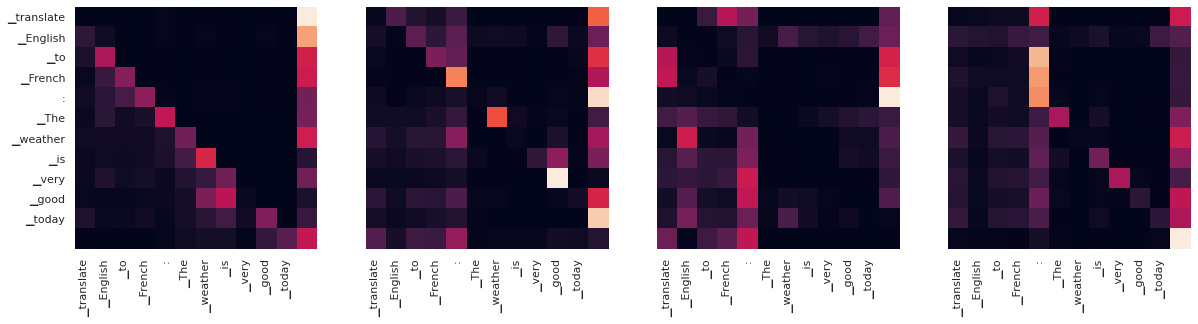

Encoder Layer 4


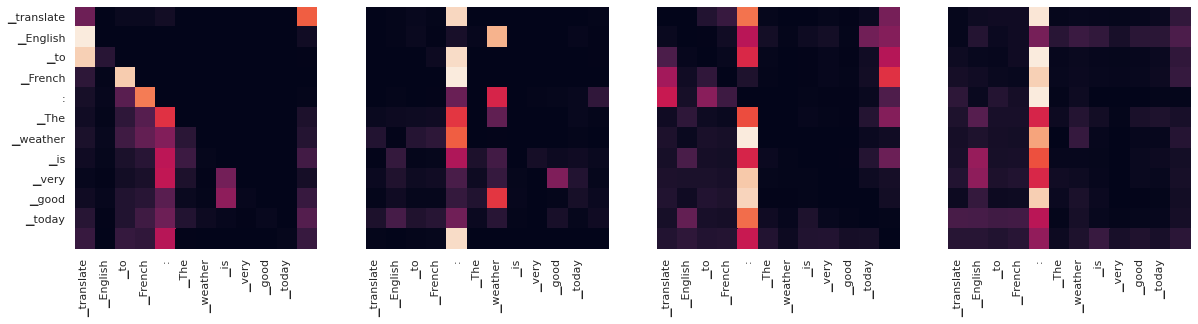

Encoder Layer 6


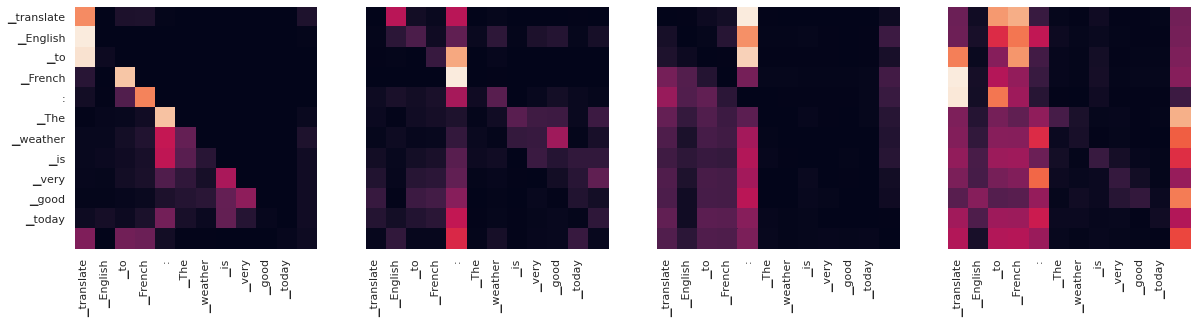

Decoder Self Layer 2


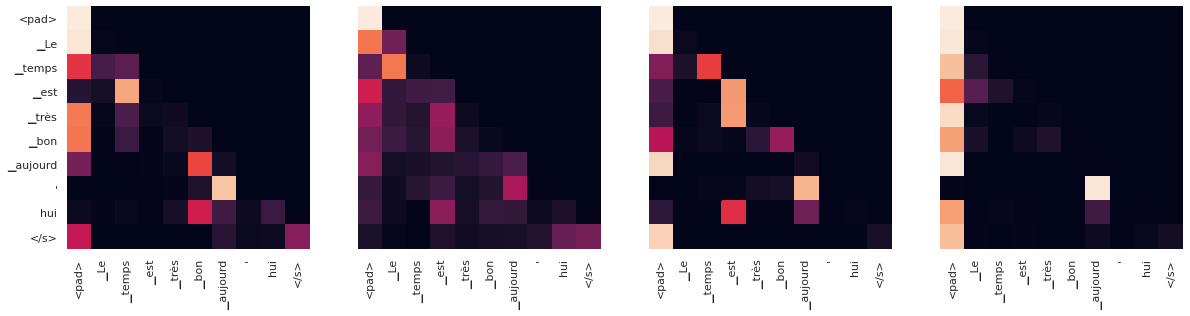

Decoder Src Layer 2


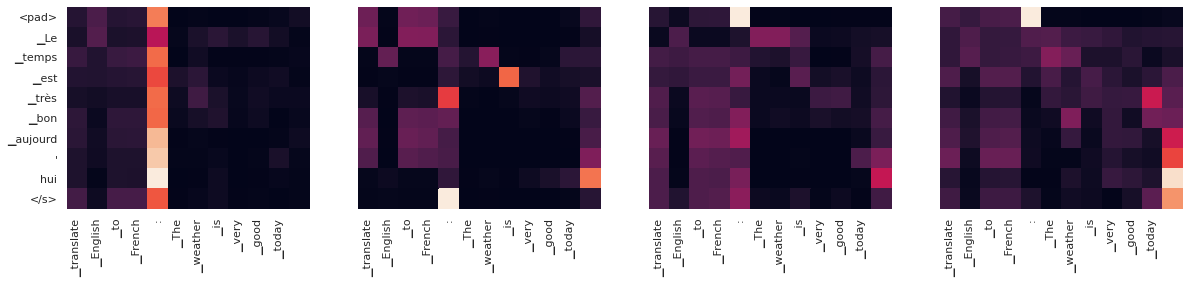

Decoder Self Layer 4


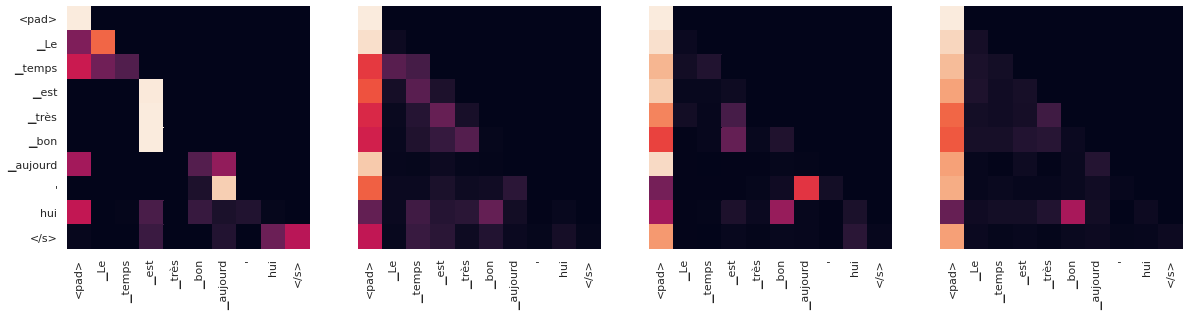

Decoder Src Layer 4


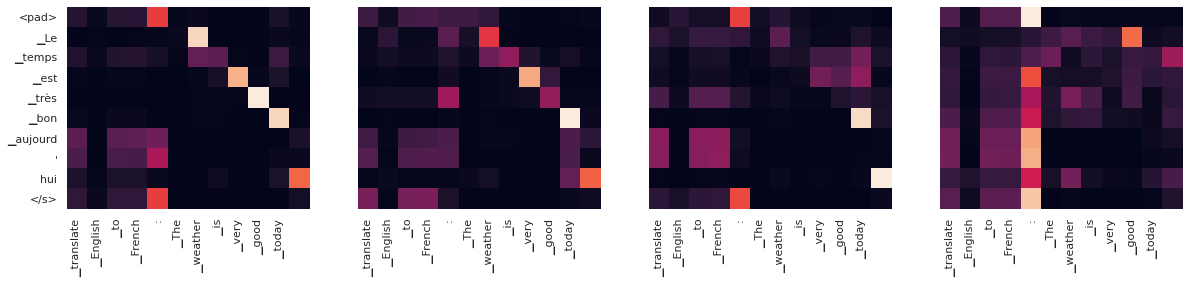

Decoder Self Layer 6


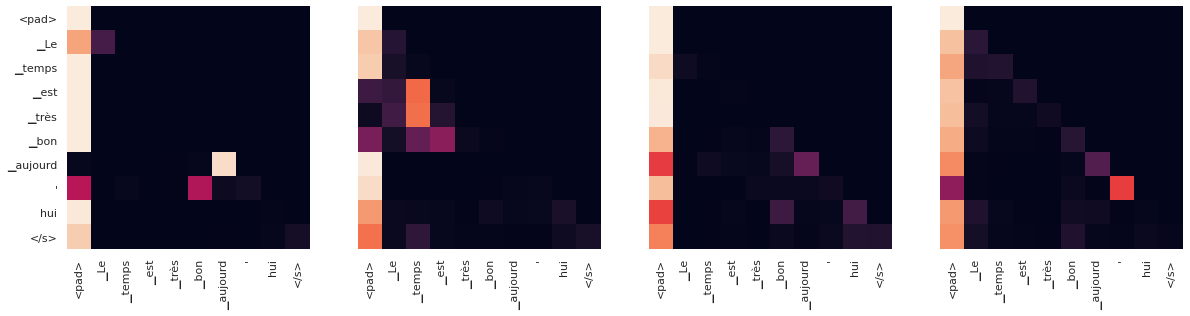

Decoder Src Layer 6


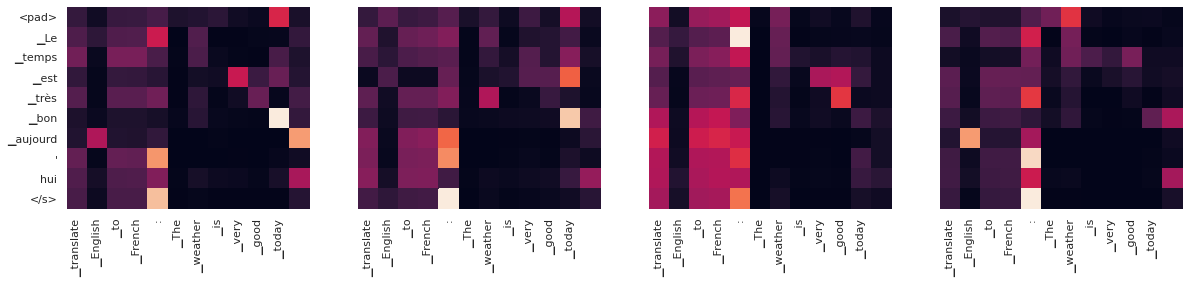

In [ ]:
import seaborn as sns
def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y, cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(encode_attention[layer].squeeze(0)[h].detach().numpy(), tokenized_text, tokenized_text if h ==0 else [], ax=axs[h])
    plt.show()

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(decode_attention[layer].squeeze(0)[h].detach().numpy(), tokenized_output, tokenized_output if h ==0 else [], ax=axs[h])
    plt.show()

    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(cross_attention[layer].squeeze(0)[h].detach().numpy(), tokenized_text, tokenized_output if h ==0 else [], ax=axs[h])
    plt.show()

### Summarization

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
import sentencepiece
tokenizer = T5Tokenizer.from_pretrained('t5-small')
config = T5Config.from_pretrained('t5-small', output_attentions=True)

#sentence = "summarize: Junk foods taste good that’s why it is mostly liked by everyone of any age group especially kids and school going children. They generally ask for the junk food daily because they have been trend so by their parents from the childhood. They never have been discussed by their parents about the harmful effects of junk foods over health. According to the research by scientists, it has been found that junk foods have negative effects on the health in many ways. They are generally fried food found in the market in the packets. They become high in calories, high in cholesterol, low in healthy nutrients, high in sodium mineral, high in sugar, starch, unhealthy fat, lack of protein and lack of dietary fibers. Processed and junk foods are the means of rapid and unhealthy weight gain and negatively impact the whole body throughout the life. It makes able a person to gain excessive weight which is called as obesity. Junk foods tastes good and looks good however do not fulfil the healthy calorie requirement of the body. Some of the foods like french fries, fried foods, pizza, burgers, candy, soft drinks, baked goods, ice cream, cookies, etc are the example of high-sugar and high-fat containing foods. It is found according to the Centres for Disease Control and Prevention that Kids and children eating junk food are more prone to the type-2 diabetes. In type-2 diabetes our body become unable to regulate blood sugar level. Risk of getting this disease is increasing as one become more obese or overweight. It increases the risk of kidney failure. Eating junk food daily lead us to the nutritional deficiencies in the body because it is lack of essential nutrients, vitamins, iron, minerals and dietary fibers. It increases risk of cardiovascular diseases because it is rich in saturated fat, sodium and bad cholesterol. High sodium and bad cholesterol diet increases blood pressure and overloads the heart functioning. One who like junk food develop more risk to put on extra weight and become fatter and unhealthier. Junk foods contain high level carbohydrate which spike blood sugar level and make person more lethargic, sleepy and less active and alert. Reflexes and senses of the people eating this food become dull day by day thus they live more sedentary life."
sentence = "summarize: Junk foods taste good that’s why it is mostly liked by everyone of any age group especially kids and school going children. They generally ask for the junk food daily because they have been trend so by their parents from the childhood. They never have been discussed by their parents about the harmful effects of junk foods over health. According to the research by scientists, it has been found that junk foods have negative effects on the health in many ways. They are generally fried food found in the market in the packets. They become high in calories, high in cholesterol, low in healthy nutrients, high in sodium mineral, high in sugar, starch, unhealthy fat, lack of protein and lack of dietary fibers. Processed and junk foods are the means of rapid and unhealthy weight gain and negatively impact the whole body throughout the life."
tokenized_text = tokenizer.tokenize(sentence)

model = T5ForConditionalGeneration.from_pretrained('t5-small', config=config)
inputs = tokenizer.encode(sentence , return_tensors="pt")
model_output_ids = model.generate(inputs, max_length=100, num_beams=4, early_stopping=True)
tokenized_output = tokenizer.tokenize(tokenizer.decode(model_output_ids[0]))
outputs = model(inputs, decoder_input_ids=model_output_ids)

encode_attention = outputs.encoder_attentions
decode_attention = outputs.decoder_attentions
cross_attention = outputs.cross_attentions

print(tokenizer.decode(model_output_ids[0]))

<pad> junk foods have negative effects on the health in many ways. they become high in calories, high in cholesterol, low in healthy nutrients, high in sodium mineral, high in sugar, starch, unhealthy fat, lack of protein and lack of dietary fiber. processed and junk foods are the means of rapid and unhealthy weight gain.</s>


Encoder Layer 2


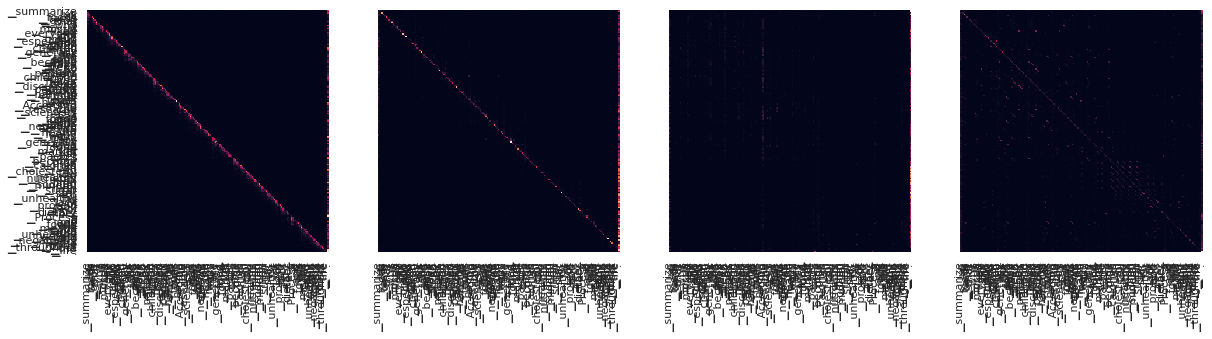

Encoder Layer 4


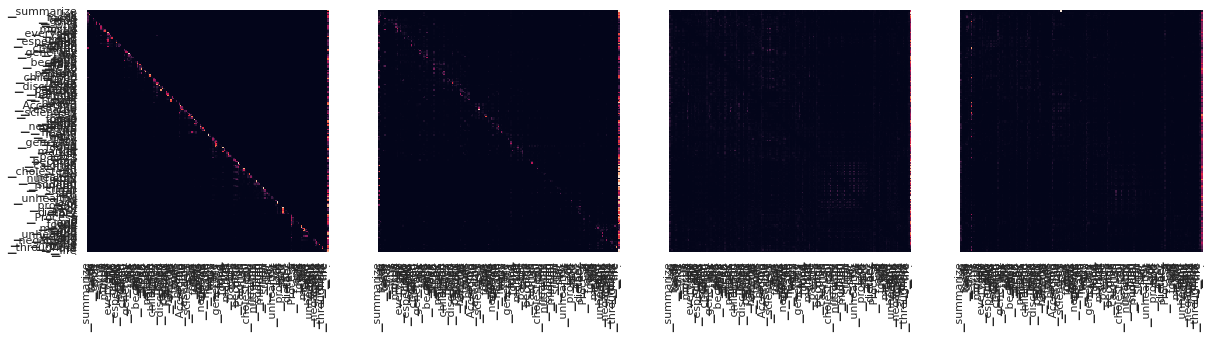

Encoder Layer 6


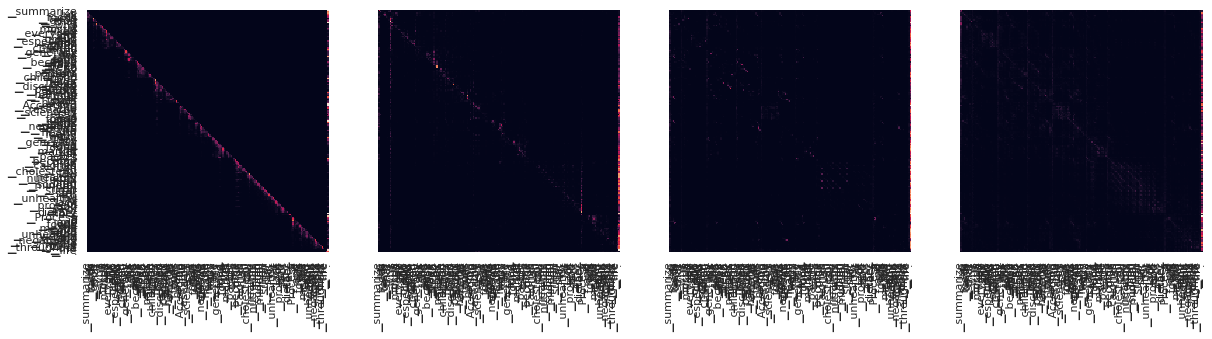

Decoder Self Layer 2


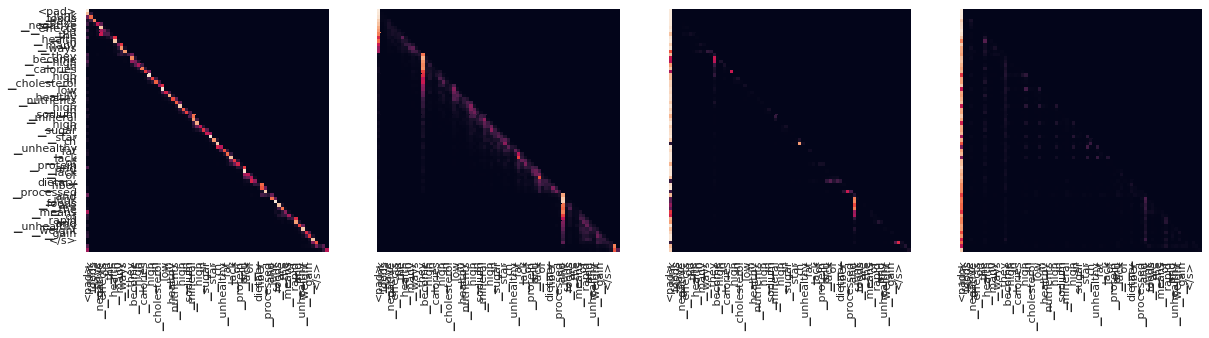

Decoder Src Layer 2


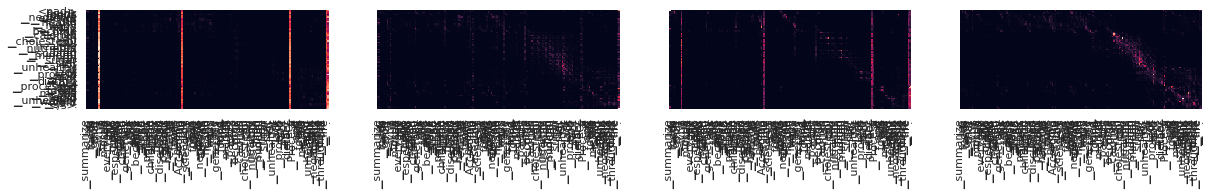

Decoder Self Layer 4


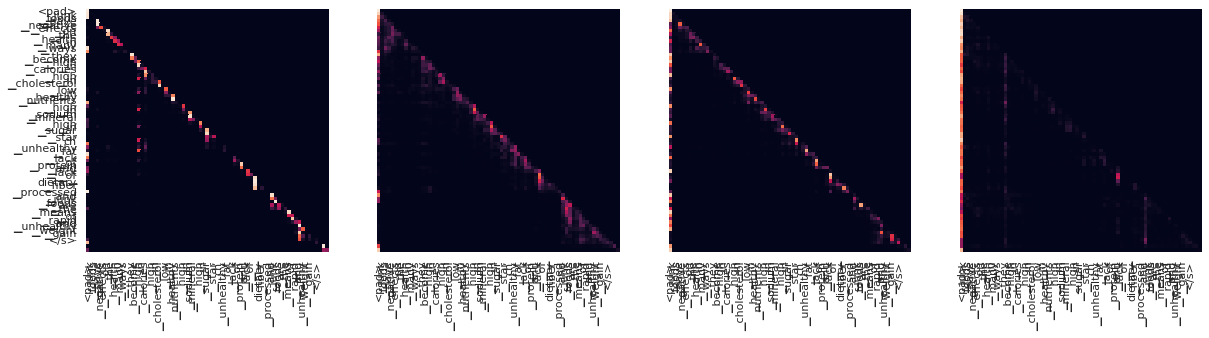

Decoder Src Layer 4


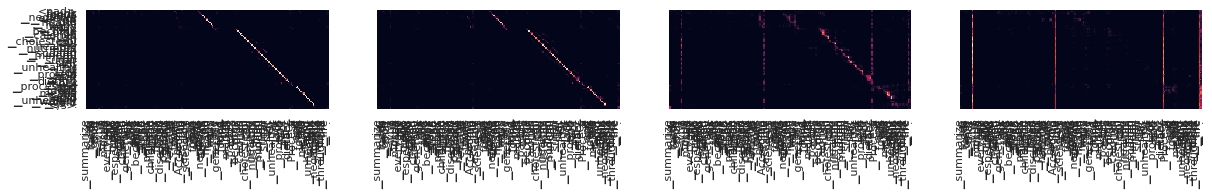

Decoder Self Layer 6


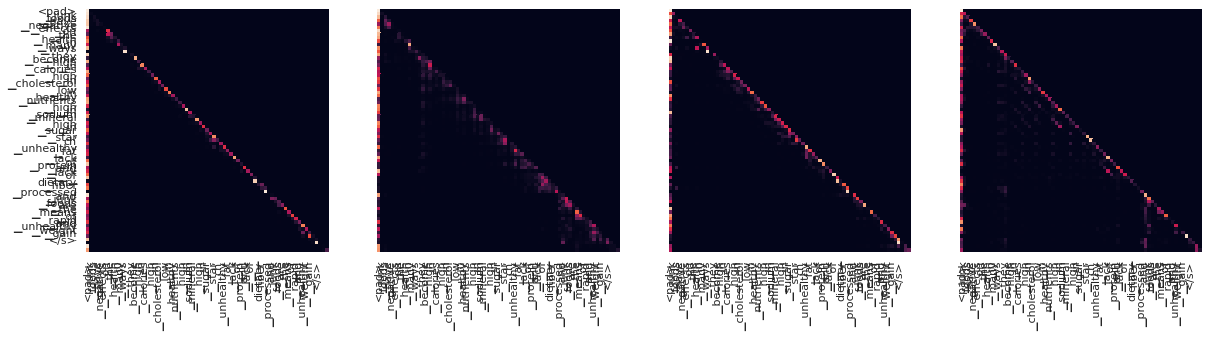

Decoder Src Layer 6


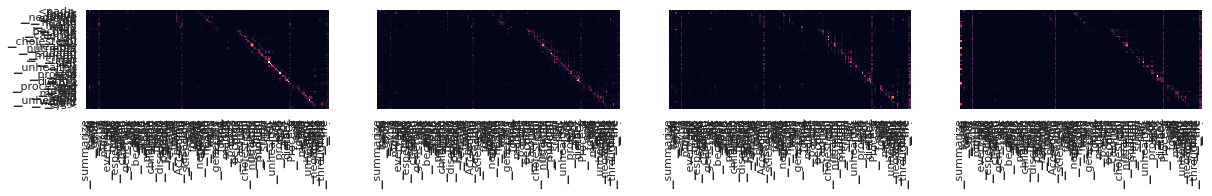

In [ ]:
import seaborn as sns
def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y, cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(encode_attention[layer].squeeze(0)[h].detach().numpy(), tokenized_text, tokenized_text if h ==0 else [], ax=axs[h])
    plt.show()

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(decode_attention[layer].squeeze(0)[h].detach().numpy(), tokenized_output, tokenized_output if h ==0 else [], ax=axs[h])
    plt.show()

    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(cross_attention[layer].squeeze(0)[h].detach().numpy(), tokenized_text, tokenized_output if h ==0 else [], ax=axs[h])
    plt.show()

### Question and Answer

In [ ]:
from datasets import load_dataset
train_dataset_boolq = load_dataset('boolq',split='train')

Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
import sentencepiece
tokenizer = T5Tokenizer.from_pretrained('t5-small')
config = T5Config.from_pretrained('t5-small', output_attentions=True)

item = 8
sentence = f"question: {train_dataset_boolq['question'][item]} context: {train_dataset_boolq['passage'][item]} "
tokenized_text = tokenizer.tokenize(sentence)

model = T5ForConditionalGeneration.from_pretrained('t5-small', config=config)
inputs = tokenizer.encode(sentence, return_tensors="pt")
model_output_ids = model.generate(inputs, max_length=100)
tokenized_output = tokenizer.tokenize(tokenizer.decode(model_output_ids[0]))
outputs = model(input_ids=inputs, decoder_input_ids=model_output_ids)

encode_attention = outputs.encoder_attentions
decode_attention = outputs.decoder_attentions
cross_attention = outputs.cross_attentions
print(model_output_ids)
print(tokenizer.decode(model_output_ids[0]))

tensor([[    0,  2146,  3080, 17410,     1]])
<pad> General George Marshall</s>


Encoder Layer 2


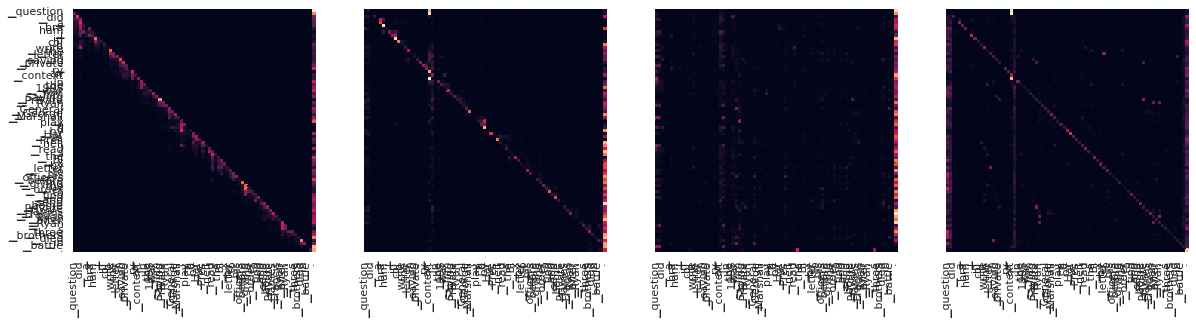

Encoder Layer 4


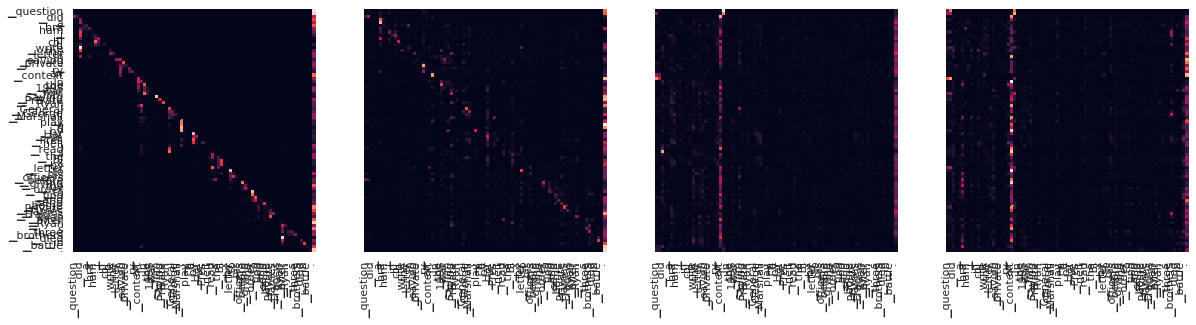

Encoder Layer 6


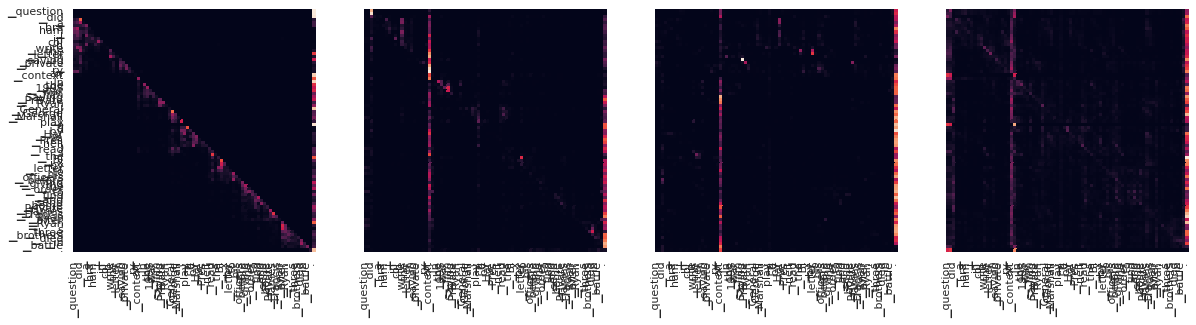

Decoder Self Layer 2


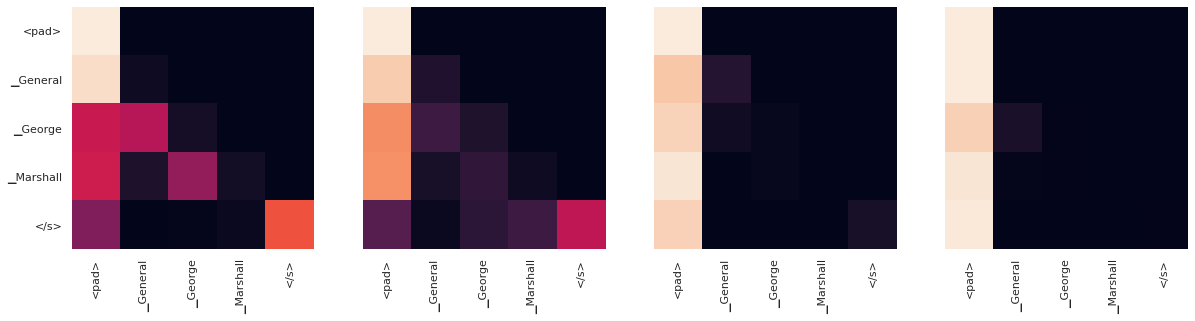

Decoder Src Layer 2


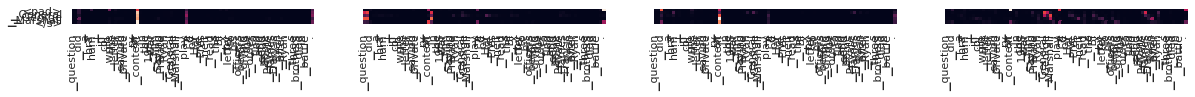

Decoder Self Layer 4


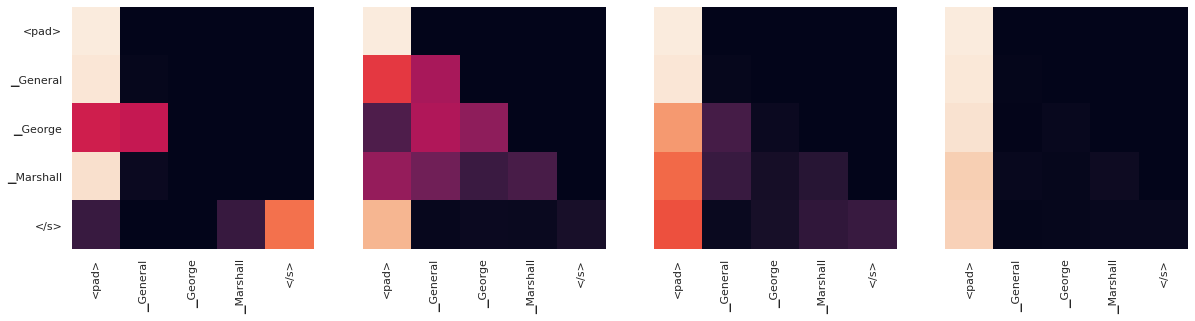

Decoder Src Layer 4


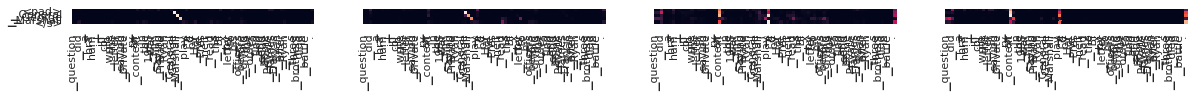

Decoder Self Layer 6


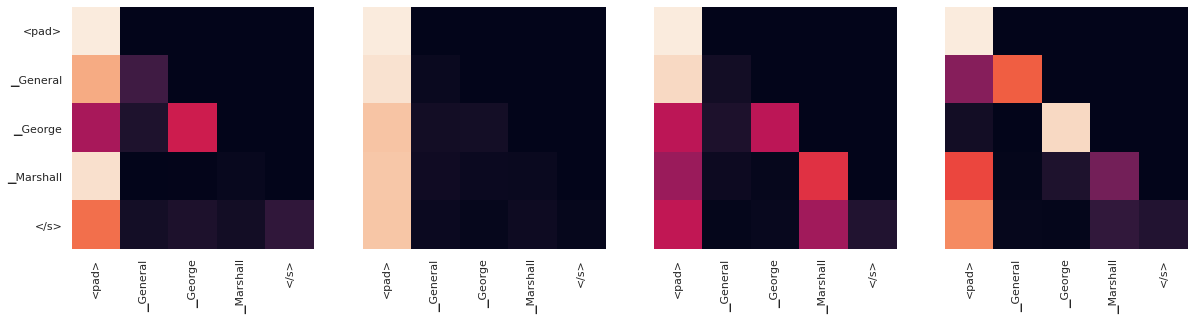

Decoder Src Layer 6


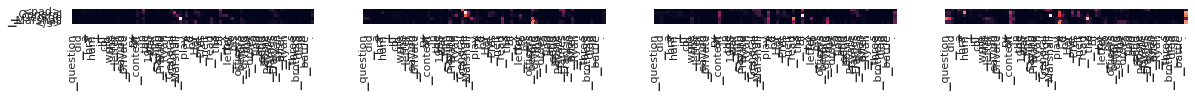

In [ ]:
import seaborn as sns
def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y, cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(encode_attention[layer].squeeze(0)[h].detach().numpy(), tokenized_text, tokenized_text if h ==0 else [], ax=axs[h])
    plt.show()

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(decode_attention[layer].squeeze(0)[h].detach().numpy(), tokenized_output, tokenized_output if h ==0 else [], ax=axs[h])
    plt.show()

    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(cross_attention[layer].squeeze(0)[h].detach().numpy(), tokenized_text, tokenized_output if h ==0 else [], ax=axs[h])
    plt.show()

###**Report**

For the above tasks, we see that the model behaves rather differently for the different tasks. For translation tasks, the attention is much more evenly spread out between the different elements of the text during self-attention. However, as the task changed to cross attention, the attention squares between the direct translations of the words from different languages light up (like "est" in the french translation showing high cross-attention with "is" in English. It is really difficult to assign any interpretability to self-attention values, however, except that some attention nodes seem to focus on specific words.

As for the summarization task, we see that most of the self-attention is based on either the word itself or its immediate neighbors. When looking at the summarization results, we can see that this is reasonable, since the summarization module often bases itself on taking key snippets of the text. This behavior is further accentuated in the decoder, where some keywords for summarization show a high level of self-attention with their neighboring words. Finally, it is also on the decoder we see the attention lighting upon certain segments of the original corpus, indicating interesting segments for extraction to the summary.

Finally, the question-answering module also had very interesting results, particularly on the cross-attention layers. It is on these layers that we see the identification of the requested subject of the question in the context paragraph. The transformer lights up for the desired information of the question, indicating its particular interest in this particular section, and enabling an extract of only the relevant information for answering the question.

## **Deliverable 2.2**
## Implement Attention Matrix Aggregation

Text(0.5, 1.0, 'Mean Max Attn Weight: Decoder Src Layer')

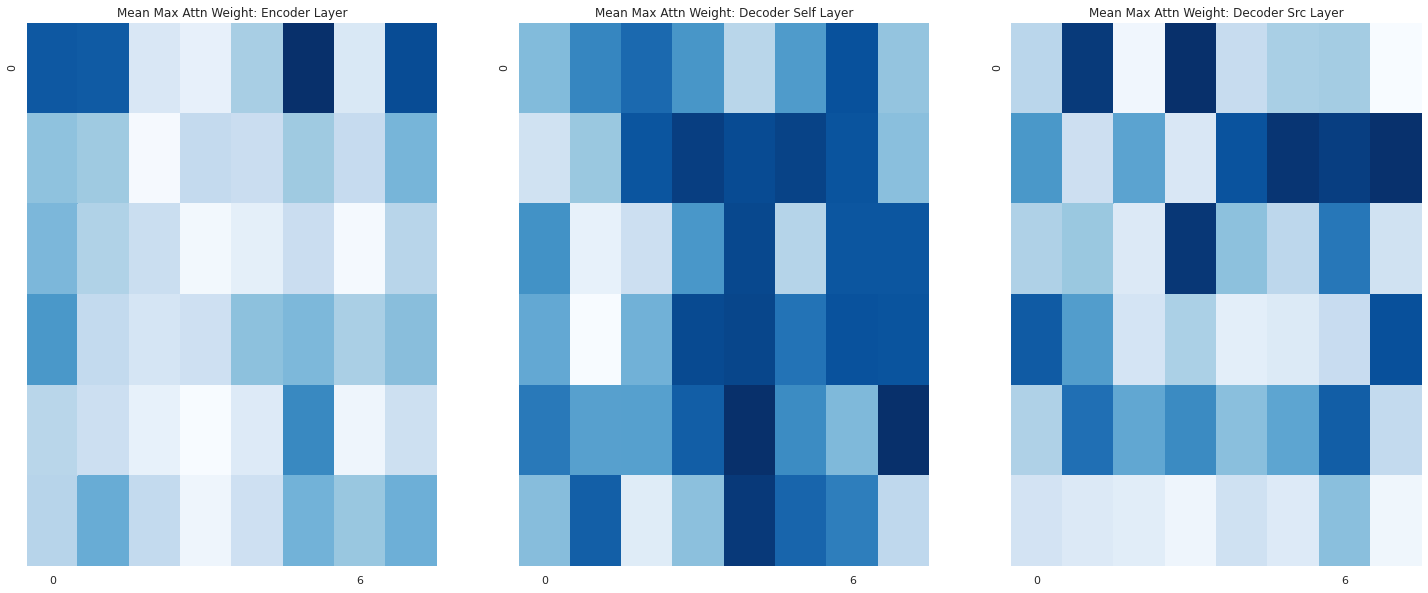

In [ ]:
import numpy as np
x = len(sentence.split())
confidence_encode = np.zeros((6,8))
confidence_decode = np.zeros((6,8))
confidence_cross = np.zeros((6,8))
fig, axs = plt.subplots(1, 3, figsize=(25, 10))

def draw(data, x, y, ax, cmap):
    sns.heatmap(data, xticklabels=6, square=False, yticklabels=8,cbar=False, ax=ax, cmap = 'Blues')

for layer in range(6):
    for h in range(8):
      att_en = encode_attention[layer][0][h].detach()
      confidence_encode[layer][h] = np.mean(np.max(att_en[:x,:x].numpy(),axis=1))
draw(confidence_encode,tokenized_text, tokenized_output if h ==0 else [], ax=axs[0], cmap = 'Blues')
axs[0].set_title("Mean Max Attn Weight: Encoder Layer")

for layer in range(6):
    for h in range(8):
      att_de = decode_attention[layer][0][h].detach()
      confidence_decode[layer][h] = np.mean(np.max(att_de[:x,:x].numpy(),axis=1))
draw(confidence_decode,tokenized_text, tokenized_output if h ==0 else [], ax=axs[1], cmap = 'Blues')
axs[1].set_title("Mean Max Attn Weight: Decoder Self Layer")

for layer in range(6):
    for h in range(8):
      att_cross = cross_attention[layer][0][h].detach()
      confidence_cross[layer][h] = np.mean(np.max(att_cross[:x,:x].numpy(),axis=1))
draw(confidence_cross,tokenized_text, tokenized_output if h ==0 else [], ax=axs[2], cmap = 'Blues')
axs[2].set_title("Mean Max Attn Weight: Decoder Src Layer")

###**Report**
On these plots, we see the overall importance of the different attention heads based on the confidence method outlined in the paper. Therefore, we can see the evolution of the attention intensity throughout the forward propagation of our phrase on the network. We can see that the encoder starts with a high level of attention overall, but the attention gets more and more dispersed as the phrase is being more processed. The decoder, however, focuses most of the attention behavior in the middle networks. 

One interesting result, however, is in the decoding src plot, representing the cross attention. It seems that it almost reaches a compromise between the early-prone encoder and the middle-prone decoder, attaining its max intensity over a very active second layer.

Another interesting result is the overall lack of stimulus on the final layer, indicating that most of the core attention tasks had been obtained before. This might indicate that there are some diminishing returns on the depth of the model as-is, and possibly justifying the choice of the original authors for only including 6 layers.

## **Deliverable Bonus 1**
## Experiment with finetuning

###**Report**

We chose 3 models which are fine-tuned specifically on translation task on the bible dataset. They are 'opus-mt-en-de', 'xlm-clm-enfr-1024', and 'xlm-mlm-enfr-1024'. 

**Evaluation**
We compared BLEU metrics for different models, T5 still show very robust performances for translation task, but we tried cnn for summarization, not necessarily T5 will performs better.

**Model interpretability:**
- Common across models:

For each model, the attention pattern in different layers don't show much difference, but the attention pattern in different heads within a layer are different.

- Differences across models:

One positive thing about Marian is that it's rather small and with good results, The models were converted in two stages. The first 1000 models use ISO-639-2 codes to identify languages, the second group use a combination of ISO-639-5 codes and ISO-639-2 codes.
As for T5, even if we use T5 small, the evaluation metrics is still robust, targeting name subjects, proper nouns, verbs, adjectives and time, which makes translation task appropraiate.

- Why T5 is still competitive although it is not specifically trained on one task ?  

Our intuition is that the multi-task training  makes T5 actually more robust. Even when not training on actual translation, the model still learns linguistic patterns that will be usefull. The attention mechanisms will then discriminate how this learned patterns will transfer from one task to another.  

So we presume there is actually synergy between the different task on which T5 is trained on.


## we use Multi-lingual models to compare results on the task of translation

In [ ]:
!git clone https://github.com/huggingface/transformers.git
%cd transformers
!pip install .
% pip install sentencepiece

fatal: destination path 'transformers' already exists and is not an empty directory.
/content/transformers
Processing /content/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.5.0.dev0-cp37-none-any.whl size=2059073 sha256=e81af8ee7e4e02579c89fb0a607498c133c75931cf725daaa791f3472d99f85e
  Stored in directory: /tmp/pip-ephem-wheel-cache-02870jwq/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
Successfully built transformers
  Found existing installation: transformers 4.5.0.dev0
    Uninstalling transformers-4.5.0.dev0:
      Successfully uninstalled transformers-4.5.0.dev0


In [ ]:
from datasets import load_dataset

# loading dataset
dataset_bible = load_dataset("bible_para", lang1="en", lang2="fr", split = 'train')
# Bible
batch_input_bible = [dataset_bible['translation'][i]['en'] for i in range(10)]
batch_input_bible = ['translate English to French: ' + s for s in batch_input_bible]
batch_output_bible = [dataset_bible['translation'][i]['fr'] for i in range(10)]

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


In [ ]:
import torch
from transformers import XLMTokenizer, XLMWithLMHeadModel
from transformers import MarianTokenizer, MarianModel

tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-en-de')
model = MarianModel.from_pretrained('Helsinki-NLP/opus-mt-en-de')


#Causal language modeling, English-French
tokenizer1 = XLMTokenizer.from_pretrained("xlm-clm-enfr-1024")
model1 = XLMWithLMHeadModel.from_pretrained("xlm-clm-enfr-1024")
#model1.config.max_length = 64


#Masked language modeling, English-French

tokenizer2 = XLMTokenizer.from_pretrained("xlm-mlm-enfr-1024")
model2 = XLMWithLMHeadModel.from_pretrained("xlm-mlm-enfr-1024")
#model2.config.max_length = 64

Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-clm-enfr-1024 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-mlm-enfr-1024 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import sentencepiece


def newmodel_output(model, tok, batch_input, batch_output, show_examples = False):
    batch_input_ids = tok(batch_input, return_tensors='pt', padding = True, max_length = 512, truncation = True).input_ids
    model_output_ids = model.generate(batch_input_ids)
    model_output = tok.batch_decode(model_output_ids, skip_special_tokens=True)
    if show_examples == True :
        for s,t,g in zip(batch_input[:5], batch_output[:5], model_output[:5]):
            print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))
    return model_output

model1_output_bible =  newmodel_output(model1,tokenizer1, batch_input_bible, batch_output_bible, show_examples = False)

In [ ]:
import numpy as np
import string
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd

def get_ngram(sentence,n=2):
  '''return a list of n-gram, bigram by default
  '''
  # remove punctuations
  s = sentence.translate(str.maketrans('', '', string.punctuation))
  words = s.lower().split(' ')
  ngrams = []
  for i in range(len(words)-n+1):
    ngrams.append(' '.join(words[i:i+n]))
  
  counts = Counter(ngrams)
  return ngrams,counts

In [ ]:
def bleuscore(reference, candidate, weights = (0.25, 0.25, 0.25, 0.25)):
    result = np.zeros(4)
    
    for n_grams_size in range(1, 5):
        _, ref_count = get_ngram(reference, n = n_grams_size)
        _, cand_count = get_ngram(candidate, n = n_grams_size)


        # counts_clip = min(counts, max_ref)
        # note that if not in counts then counts = 
        count_clip = Counter()
        for k, v in cand_count.items():
            count_clip[k] = min(v, ref_count[k])
        
        if sum(cand_count.values()) != 0:
            frac = sum(count_clip.values()) / sum(cand_count.values())
        else:
            return 1
        result[n_grams_size-1] = frac



    if len(candidate.split())>len(reference.split()):
        bp = 1
    else:
        bp = np.exp(1-len(reference.split())/len(candidate.split()))

    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.log(result)
        result[np.isneginf(result)]=0
        return bp * np.exp(np.sum(weights*result))

In [ ]:
batch_input_bible = []
batch_output_bible = []

data = dataset_bible['translation']
for i in range(1000):
    item = data[i]
    batch_input_bible.append('translate English to French: ' + item['en'])
    batch_output_bible.append(item['fr'])

In [ ]:
model1_output_bible =  newmodel_output(model1,tokenizer1, batch_input_bible, batch_output_bible)

Input length of input_ids is 88, but ``max_length`` is set to 64.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


In [ ]:
bible_bleu_results1 = pd.DataFrame(columns=['original', 'human-translation', 'xlm-translation', 'nltk-bleu', 'our-bleu'])

for i in range(1000):
    row = {'original': batch_input_bible[0], 
                            'human-translation': batch_output_bible[i],
                            'xlm-translation': model1_output_bible[i],
                            'nltk-bleu': sentence_bleu([batch_output_bible[i].split()], model1_output_bible[i].split()),
                            'our-bleu': bleuscore(batch_output_bible[i], model1_output_bible[i])}

    bible_bleu_results1 = bible_bleu_results1.append(row, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
bible_bleu_results1

,original,human-translation,xlm-translation,nltk-bleu,our-bleu
0,translate English to French: In the beginning ...,"Au commencement, Dieu créa les cieux et la terre.",translate english to french : in the beginning...,0,1.000000
1,translate English to French: In the beginning ...,La terre était informe et vide: il y avait des...,translate english to french : now the earth wa...,0.427287,0.427287
2,translate English to French: In the beginning ...,Dieu dit: Que la lumière soit! Et la lumière fut.,"translate english to french : god said, "" let ...",0,1.000000
3,translate English to French: In the beginning ...,Dieu vit que la lumière était bonne; et Dieu s...,translate english to french : god saw the ligh...,0,1.000000
4,translate English to French: In the beginning ...,"Dieu appela la lumière jour, et il appela les ...",translate english to french : god called the l...,0,1.000000
...,...,...,...,...,...
995,translate English to French: In the beginning ...,Nous ne consentirons à votre désir qu`à la con...,translate english to french : only on this con...,0.430924,0.430924
996,translate English to French: In the beginning ...,"Nous vous donnerons alors nos filles, et nous ...",translate english to french : then will we giv...,0,1.000000
997,translate English to French: In the beginning ...,Mais si vous ne voulez pas nous écouter et vou...,translate english to french : but if you will ...,0,1.000000
998,translate English to French: In the beginning ...,Leurs paroles eurent l`assentiment de Hamor et...,translate english to french : their words plea...,0,0.526640


In [ ]:
model2_output_bible =  newmodel_output(model2,tokenizer2, batch_input_bible, batch_output_bible)

Input length of input_ids is 88, but ``max_length`` is set to 64.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


In [ ]:

bible_bleu_results2 = pd.DataFrame(columns=['original', 'human-translation', 'xlm-translation', 'nltk-bleu', 'our-bleu'])

for i in range(1000):
    row = {'original': batch_input_bible[i], 
                            'human-translation': batch_output_bible[i],
                            'xlm-translation': model1_output_bible[i],
                            'nltk-bleu': sentence_bleu([batch_output_bible[i].split()], model1_output_bible[i].split()),
                            'our-bleu': bleuscore(batch_output_bible[i],model2_output_bible[i])}

    bible_bleu_results2 = bible_bleu_results2.append(row, ignore_index=True)


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
bible_bleu_results2

,original,human-translation,xlm-translation,nltk-bleu,our-bleu
0,translate English to French: In the beginning ...,"Au commencement, Dieu créa les cieux et la terre.",translate english to french : in the beginning...,0,1.000000
1,translate English to French: Now the earth was...,La terre était informe et vide: il y avait des...,translate english to french : now the earth wa...,0.427287,0.427287
2,"translate English to French: God said, ""Let th...",Dieu dit: Que la lumière soit! Et la lumière fut.,"translate english to french : god said, "" let ...",0,1.000000
3,translate English to French: God saw the light...,Dieu vit que la lumière était bonne; et Dieu s...,translate english to french : god saw the ligh...,0,1.000000
4,translate English to French: God called the li...,"Dieu appela la lumière jour, et il appela les ...",translate english to french : god called the l...,0,1.000000
...,...,...,...,...,...
995,translate English to French: Only on this cond...,Nous ne consentirons à votre désir qu`à la con...,translate english to french : only on this con...,0.430924,0.430924
996,translate English to French: then will we give...,"Nous vous donnerons alors nos filles, et nous ...",translate english to french : then will we giv...,0,1.000000
997,translate English to French: But if you will n...,Mais si vous ne voulez pas nous écouter et vou...,translate english to french : but if you will ...,0,1.000000
998,translate English to French: Their words pleas...,Leurs paroles eurent l`assentiment de Hamor et...,translate english to french : their words plea...,0,0.526640


In [ ]:
from transformers import MarianTokenizer, MarianModel

tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-en-de')
model = MarianModel.from_pretrained('Helsinki-NLP/opus-mt-en-de', output_attentions=True)

sentence = "Studies have been shown that owning a dog is good for you"
output_sentence = "<pad> Studien haben gezeigt dass es hilfreich ist einen Hund zu besitzen"

input_ids = tokenizer("Studies have been shown that owning a dog is good for you", return_tensors="pt").input_ids  # Batch size 1
decoder_input_ids = tokenizer("<pad> Studien haben gezeigt dass es hilfreich ist einen Hund zu besitzen",return_tensors="pt", add_special_tokens=False).input_ids  # Batch size 1
outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)

In [ ]:
encode_attention = outputs.encoder_attentions
decode_attention = outputs.decoder_attentions
cross_attention = outputs.cross_attentions

In [ ]:
encode_attention[3][0][7]

tensor([[5.1592e-02, 4.9243e-03, 7.4098e-03, 8.0824e-03, 1.3056e-04, 8.9151e-04,
         6.5793e-04, 2.0266e-03, 1.9833e-02, 1.8715e-03, 1.8647e-02, 1.3714e-02,
         1.9696e-02, 8.5052e-01],
        [9.2329e-03, 2.1608e-02, 7.7142e-02, 6.1773e-03, 2.2019e-03, 1.9036e-03,
         3.1170e-04, 2.2284e-03, 4.0880e-03, 4.8747e-04, 4.4847e-03, 3.7981e-03,
         3.6526e-03, 8.6268e-01],
        [5.9547e-02, 6.5310e-03, 9.2449e-02, 2.3401e-02, 4.8928e-03, 2.3924e-03,
         3.4617e-04, 6.3821e-03, 6.0187e-04, 3.9040e-04, 2.8613e-03, 1.4667e-03,
         6.8829e-04, 7.9805e-01],
        [1.5625e-01, 9.3945e-03, 2.3728e-02, 1.0012e-02, 1.6623e-03, 1.0507e-03,
         1.5179e-04, 2.2905e-03, 2.5925e-03, 2.4369e-03, 5.8099e-03, 8.7518e-03,
         1.8464e-02, 7.5741e-01],
        [1.6505e-01, 3.4186e-02, 9.1390e-03, 1.9021e-01, 1.1882e-02, 2.8976e-03,
         1.3646e-04, 2.7016e-03, 2.1775e-04, 1.1826e-03, 5.7192e-03, 1.7709e-03,
         1.1531e-03, 5.7376e-01],
        [1.0802e-02,

Encoder Layer 2


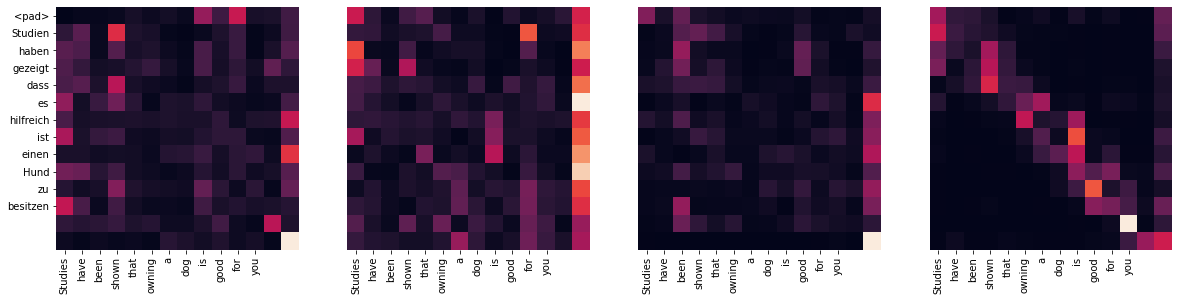

Encoder Layer 4


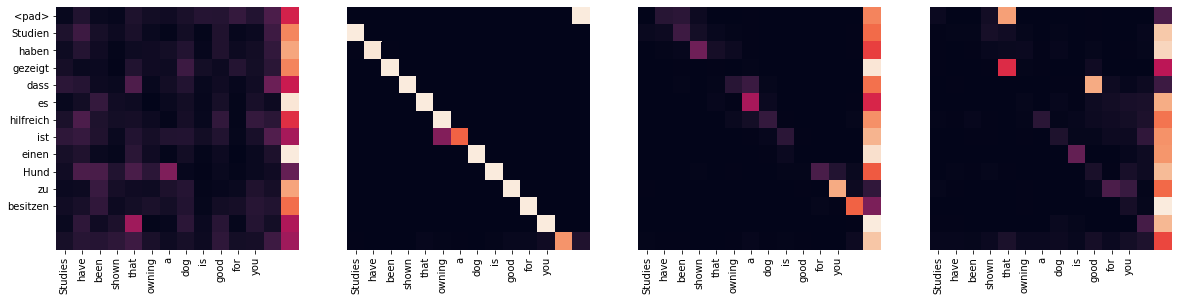

Encoder Layer 6


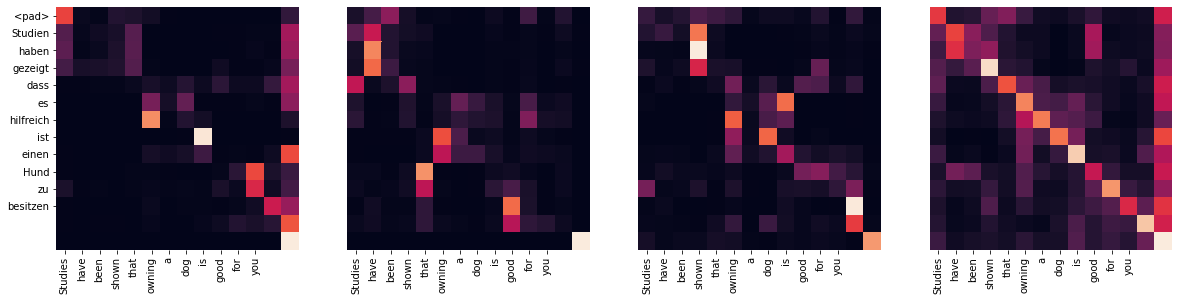

Decoder Self Layer 2


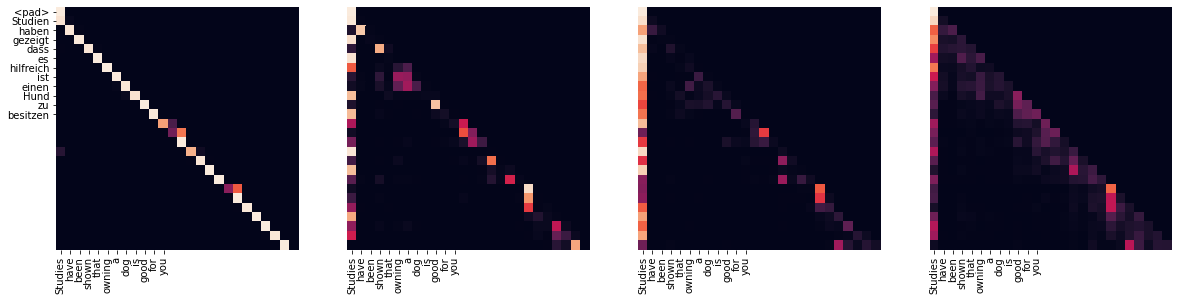

Decoder Src Layer 2


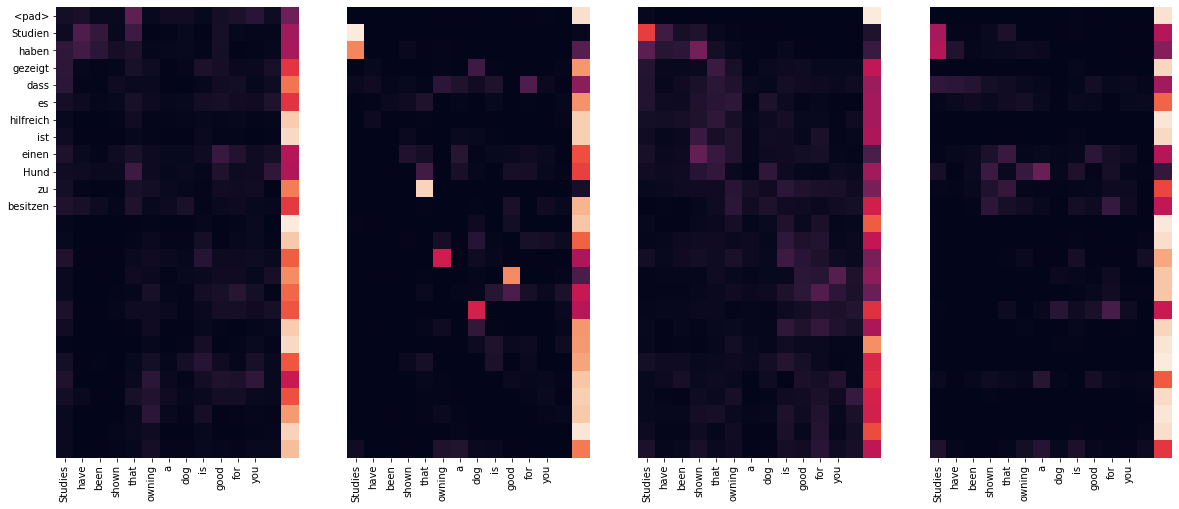

Decoder Self Layer 4


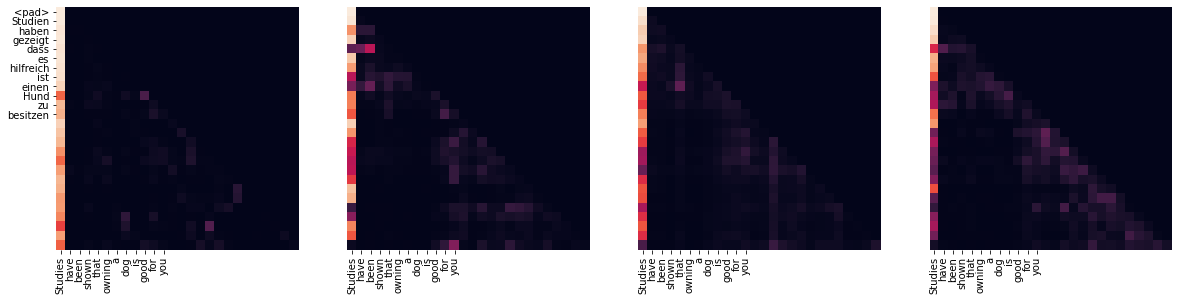

Decoder Src Layer 4


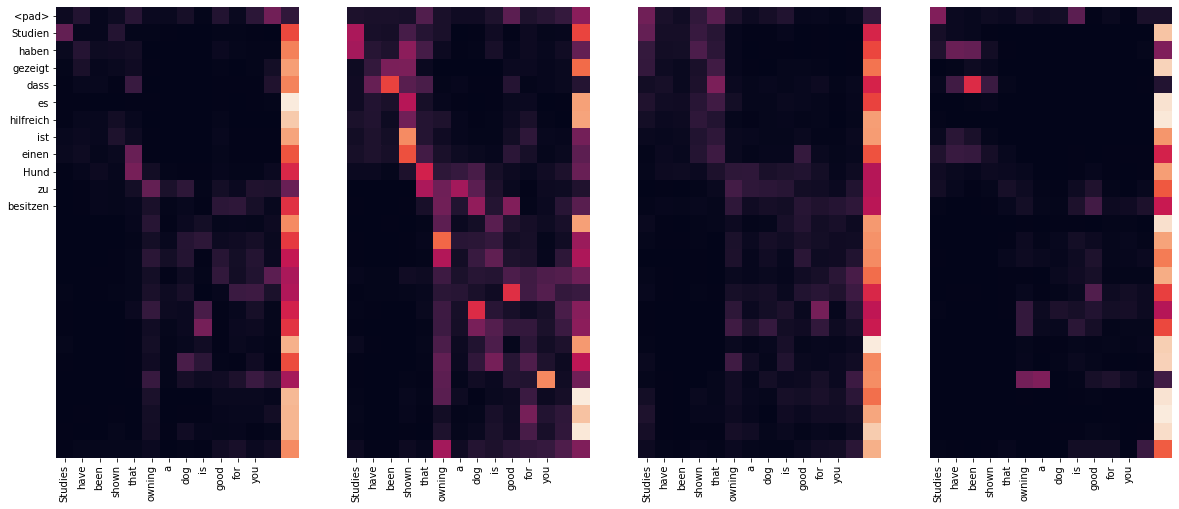

Decoder Self Layer 6


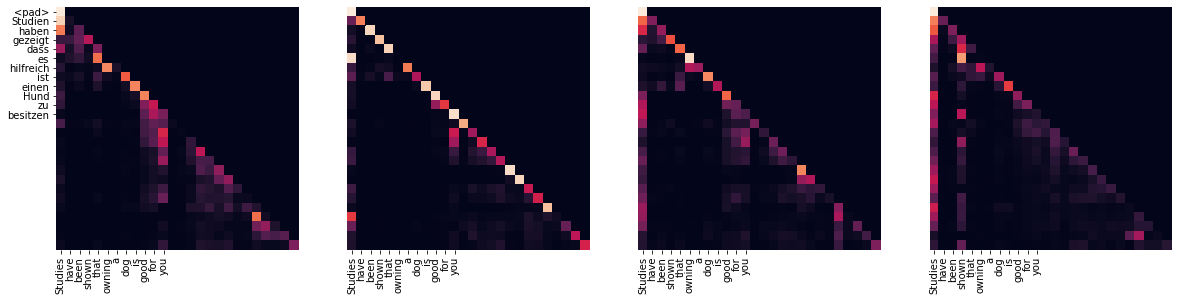

Decoder Src Layer 6


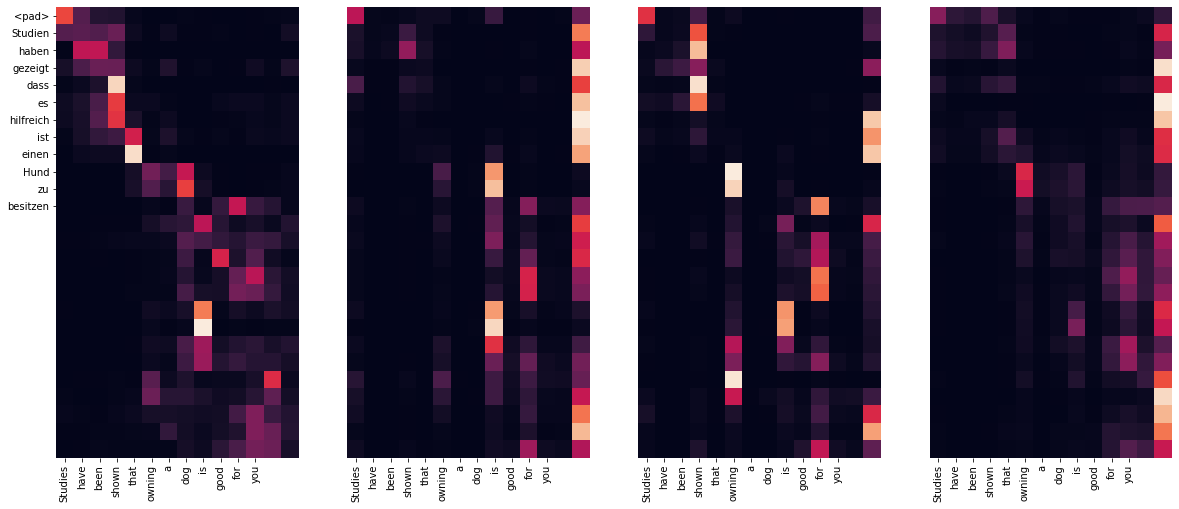

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sentence = "Studies have been shown that owning a dog is good for you"
output_sentence = "<pad> Studien haben gezeigt dass es hilfreich ist einen Hund zu besitzen"
sentence = sentence.split()
output_sentence = output_sentence.split()
def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y,cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(encode_attention[layer][0][h].detach().numpy(), sentence, output_sentence if h ==0 else [], ax=axs[h])
    plt.show()

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(decode_attention[layer][0][h].detach().numpy(), sentence, output_sentence if h ==0 else [], ax=axs[h])
    plt.show()

    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(cross_attention[layer][0][h].detach().numpy(), sentence, output_sentence if h ==0 else [], ax=axs[h])
    plt.show()

In [ ]:
from transformers import MarianTokenizer, MarianModel

tokenizer = XLMTokenizer.from_pretrained("xlm-clm-enfr-1024")
model = XLMWithLMHeadModel.from_pretrained("xlm-clm-enfr-1024", output_attentions=True)

#tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-en-de')
#model = MarianModel.from_pretrained('Helsinki-NLP/opus-mt-en-de')

sentence = "translate English to French: The weather is very good today"
tokenized_text = tokenizer.tokenize(sentence)

inputs = tokenizer.encode(sentence , return_tensors="pt")
model_output_ids = model.generate(inputs, max_length=32, num_beams=4, early_stopping=True)
tokenized_output = tokenizer.tokenize(tokenizer.decode(model_output_ids[0]))
outputs = model(inputs)

Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-clm-enfr-1024 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text(0.5, 1.0, 'Mean Max Attn Weight: Decoder Src Layer')

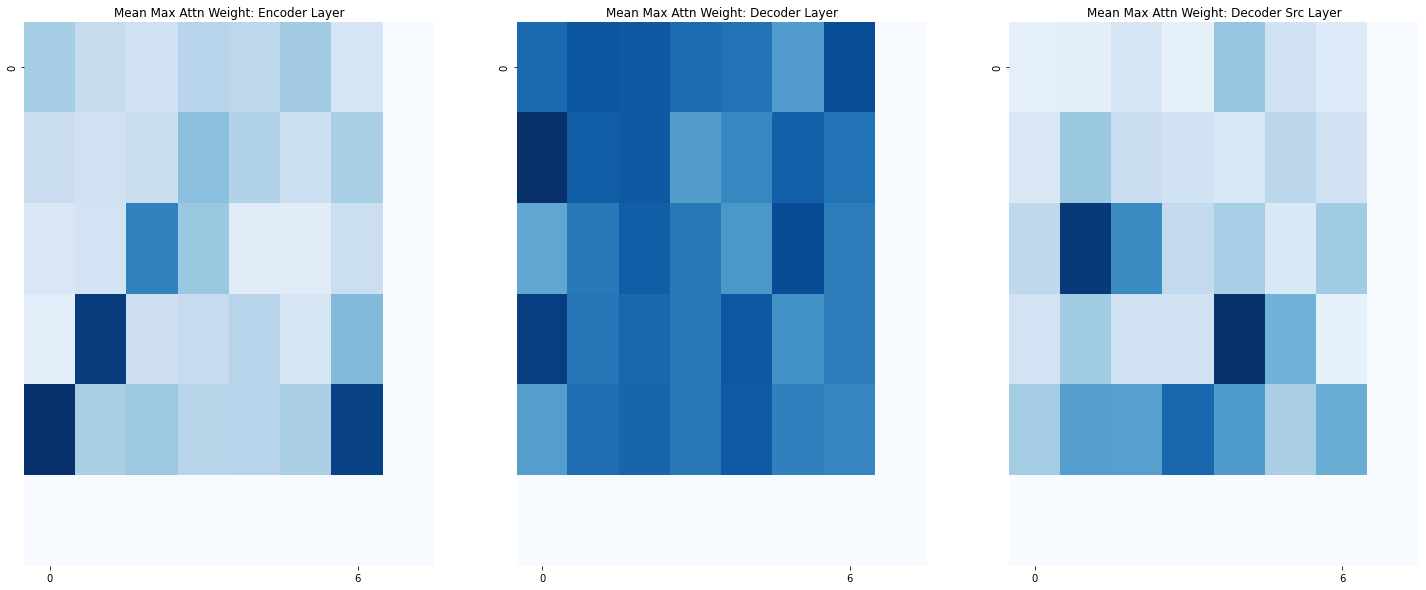

In [ ]:
import numpy as np
sentence =  "Studies have been shown that owning a dog is good for you"
x = len(sentence.split())
confidence_encode = np.zeros((6,8))
confidence_decode = np.zeros((6,8))
confidence_cross = np.zeros((6,8))
fig, axs = plt.subplots(1, 3, figsize=(25, 10))

def draw(data, x, y, ax, cmap):
    sns.heatmap(data, xticklabels=6, square=False, yticklabels=8,cbar=False, ax=ax, cmap = 'Blues')

for layer in range(5):
    for h in range(7):
      att_en = encode_attention[layer][0][h].detach()
      confidence_encode[layer][h] = np.mean(np.max(att_en[:x,:x].numpy(),axis=1))
draw(confidence_encode,tokenized_text, tokenized_output if h ==0 else [], ax=axs[0], cmap = 'Blues')
axs[0].set_title("Mean Max Attn Weight: Encoder Layer")

for layer in range(5):
    for h in range(7):
      att_de = decode_attention[layer][0][h].detach()
      confidence_decode[layer][h] = np.mean(np.max(att_de[:x,:x].numpy(),axis=1))
draw(confidence_decode,tokenized_text, tokenized_output if h ==0 else [], ax=axs[1], cmap = 'Blues')
axs[1].set_title("Mean Max Attn Weight: Decoder Layer")

for layer in range(5):
    for h in range(7):
      att_cross = cross_attention[layer][0][h].detach()
      confidence_cross[layer][h] = np.mean(np.max(att_cross[:x,:x].numpy(),axis=1))
draw(confidence_cross,tokenized_text, tokenized_output if h ==0 else [], ax=axs[2], cmap = 'Blues')
axs[2].set_title("Mean Max Attn Weight: Decoder Src Layer")

## **Deliverable Bonus 2**
## Implement Minimum Bayes Risk Decoding

###**Report**

We built a basic MBR Decoding with METEOR metric.

The logic behing MBR is comparable to a voting in Ensemble Learning. Here we try to find a 'consensus' translation, by maximizing the cross similarity of each candidate translation compared to all the other translations.

We need to do the random sampling for several times, for each time we need to record the score and then we find the highest to be our final choice.

##Implementation of MBR decoding

MBR decoding aims to minimize the expected word error rate, assuming the lattice encodes the true uncertainty about what was spoken; standard Viterbi decoding gives the most likely utterance, which corresponds to minimizing the expected sentence error rate.

In [ ]:
!pip install nltk==3.5
import nltk
from nltk.translate import meteor
nltk.download('wordnet')

In [ ]:
def mbr_decode(sentence, n_samples, similarity_fn, temperature=0.8, top_p = 0.8):
    # tokenize sentence
    sentence_ids = tok(sentence, return_tensors='pt', padding = True, max_length = 512, truncation = True).input_ids
    samples_of_translations = []

    # sample translations
    for i in range(nb_samples):
        model_output_ids = model.generate(sentence_ids, do_sample=True, max_length=512, top_p=top_p, temperature = temperature)
        samples_of_translations.append(tok.batch_decode(model_output_ids, skip_special_tokens=True)[0])

    # compute cross-utility
    utilities = np.zeros(nb_samples)
    for i in range(nb_samples) :
        utilities[i] = sum([similarity_fn(translation, samples_of_translations[i]) for translation in samples_of_translations])
    # find arg max
    index_max = np.argmax(utilities)

    return samples_of_translations[index_max]

In [ ]:
sentence = batch_input_ted[2]
reference = batch_output_ted[2]

mbr_translation = mbr_decode(sentence, n_samples = 30, similarity_fn = meteor, temperature = 0.8, top_p = 0.8)

### Comparing Beam Search and MBR

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

beam_output_ids = model.generate(sentence_ids,max_length=512, num_beams = 5)
beam_5_translation = tok.batch_decode(beam_output_ids, skip_special_tokens=True)[0]

beam_output_ids = model.generate(sentence_ids,max_length=512, num_beams = 10)
beam_10_translation = tok.batch_decode(beam_output_ids, skip_special_tokens=True)[0]

beam_output_ids = model.generate(sentence_ids,max_length=512, num_beams = 15)
beam_15_translation = tok.batch_decode(beam_output_ids, skip_special_tokens=True)[0]

print('BLEU score for 5 beams :', sentence_bleu(reference, beam_5_translation))
print('BLEU score for 10 beams :', sentence_bleu(reference, beam_10_translation))
print('BLEU score for 15 beams :', sentence_bleu(reference, beam_15_translation))
print('BLEU score for MBR :', sentence_bleu(reference, mbr_translation))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

BLEU score for 5 beams : 1.012071042130996e-231
BLEU score for 10 beams : 1.013799606997597e-231
BLEU score for 15 beams : 1.013799606997597e-231
BLEU score for MBR : 1.2015238684369537e-231


Our MBR decoding has better score than Beam Search